# Image Classifier zur automatisierten Müllklassifizierung und Trennhilfe

**Modul:** 113451 Ausgewählte Anwendungen der KI (Selected Topics of AI) <br>
**Professor:** Prof. Dr. Johannes Maucher <br>
**Bearbeitet von:** Julia Ebert (je073), Lars Gerigk (lg107), Joel Starkov (js486) <br>
**Abgabe:** 28.01.2026 <br>

## Inhaltsverzeichnis

<table style="border:none; border-collapse:collapse">
  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#1-problemstellung-und-zielsetzung" style="color:inherit; text-decoration:none;">
          1. Problemstellung und Zielsetzung
        </a>
      </b>
    </td>
    <td style="border:none; width:100%">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>1.1 Motivation und Problemanalyse</li>
        <li>1.2 Ziel
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>1.2.1 Zielunterscheidung</li>
          </ul>
        </li>
        <li>1.3 Fragestellungen</li>
        <li>1.4 Abgrenzung der Müllkategorien</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#2-installation-und-setup" style="color:inherit; text-decoration:none;">
          2. Installation und Setup
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>2.1 Installation optional</li>
        <li>2.2 Imports</li>
        <li>2.3 Globale Konfigurationen und Utils
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>2.3.1 Reproduzierbarkeit</li>
            <li>2.3.2 Device Konfiguration</li>
            <li>2.3.3 Zentrale Hyperparameter Konfiguration</li>
            <li>2.3.4 Allgemeine Konfigurationen</li>
            <li>2.3.5 Konfigurationen der Modellarchitekturen</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#3-datensetanalyse" style="color:inherit; text-decoration:none;">
          3. Datensetanalyse
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>3.1 Herkunft der Daten
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>3.1.1 Externer Datensatz</li>
            <li>3.1.2 Eigener Datensatz</li>
          </ul>
        </li>
        <li>3.2 Zusammenführung und manuelle Strukturierung</li>
        <li>3.3 Datenqualität</li>
        <li>3.4 Ausgangsstruktur der Daten</li>
        <li>3.5 Datenaufbereitung
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>3.5.1 Import der Bilder</li>
            <li>3.5.2 Bildverarbeitung</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#4-modellarchitekturen" style="color:inherit; text-decoration:none;">
          4. Modellarchitekturen
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>4.1 Multi Layer Perceptron</li>
        <li>4.2 Convolutional Neural Network</li>
        <li>4.3 Transfer Learning
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>4.3.1 VGG16</li>
            <li>4.3.2 ResNet50</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#5-training-und-evaluation" style="color:inherit; text-decoration:none;">
          5. Training und Evaluation
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>5.1 Funktionen</li>
        <li>5.2 Pipelines</li>
        <li>5.3 Hyperparameteroptimierung mit Weights and Bias</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#6-quellen" style="color:inherit; text-decoration:none;">
          6. Quellen
        </a>
      </b>
    </td>
    <td style="border:none"></td>
  </tr>

</table>


## 1. Problemstellung & Zielsetzung 
### 1.1. Motivation & Problemanalyse <a id="motivation"></a>

Die korrekte Trennung von Abfällen stellt für viele eine Herausforderung dar. Eine Umfrage von ALBA und Civey aus dem Jahr 2022 zeigt, dass nur 3,8% der Befragten Teilnehmer aus einer Stichprobengröße von 2.502 Menschen ihren Müll nicht trennen. Besonders hervorsticht, dass über 90% der Befragten, darauf achten Papier und Pappe vom Restmüll zu trennen. 87,3 % der Befragten trennen ihre Plastik(-verpackungen) vom Restmüll und 83,8 % trennen ihr Altglas vom Restmüll. Mit 64,4 % Müll trennen die Befragten am wenigsten von Biomüll und Restmüll. Diese Ergebnisse hören sich zunächst vielversprechend an. Allerdings täsuchen diese Ergebnisse, so der ALBA-Chef Eric Schweitzer. Eine Studie des Umweltbundesamtes zeigt auf, dass zwei Drittel des Inhalts der Restmülltonne, getrennt gesammelt und recycelt werden könnte. Zudem sagt Schweitzer aus, dass "Fehlerwürfe" von bis zu 30 Prozent keine Seltenheit ist. Somit werden Ressourcen folglich verbrannt, die die Gesamtkosten für Energie und die Produktion neuer Rohstoffe steigen für die Gesellschaft [1]. 

Fehlwürfe in der Mülltrennung lassen sich unter anderem auf ein fehlendes grundlegendes Verständnis des Abfalltrennungssystems sowie auf eine unzureichende und nicht einheitliche Aufklärung zurückführen. Die bestehenden Trennregeln sind teilweise komplex und unterscheiden sich je nach Region, was die korrekte Zuordnung einzelner Abfallarten erschwert. Durch die entstandenen Unsicherheiten führen in der Praxis zu erhöhten Fehlwürfen und beeinträchtigen die Effizienz von Recyclingprozessen [2].

Im Folgenden wird ein Anwendungsbeispiel für den Einsatz eines bildbasierten Klassifikationssystems an der Hochschule der Medien (kurz: HdM) vorgestellt. Ziel ist es, die Mülltrennung und damit die Recyclingqualität auf dem Campus zu verbessern. Zu diesem Zweck wird ein Image Classifier entwickelt, der anhand eines aufgenommenen Bildes eines Abfallobjekts dessen Kategorie erkennt und den Nutzer bei der korrekten Entsorgung unterstützt.

Ein möglicher Ausblick besteht darin, Abfallbehälter mit einer integrierten Kamera sowie einem visuellen und auditiven Rückmeldesystem auszustatten. Nach der automatischen Klassifikation gibt das System an der jeweiligen Einwurföffnung ein Signal aus, das anzeigt, in welchen Behälter der Abfall entsorgt werden soll. Durch die Kombination aus visueller und auditiver Rückmeldung kann die Bedienung vereinfacht und gleichzeitig sprachliche sowie visuelle Barrieren reduziert werden. Auf diese Weise könnte das System dazu beitragen, Fehlwürfe zu verringern und die Mülltrennung im Hochschulalltag nachhaltig zu verbessern.


### 1.2. Ziel 

Ziel dieses Projekts ist die Entwicklung eines Image Classifiers zur automatisierten Erkennung und Zuordnung von Abfallobjekten. Hierfür werden parallel zu den in der Vorlesung behandelten Konzepten und Modellen geeignete Architekturen ausgewählt, implementiert und an die Anforderungen des vorliegenden Anwendungsfalls angepasst. Die entwickelten Modelle werden trainiert, validiert und hinsichtlich ihrer Leistungsfähigkeit systematisch untersucht.

Zur Bewertung der Modellgüte werden etablierte Metriken wie Accuracy, Precision, Recall und F1 Score herangezogen. Die Ergebnisse der einzelnen Modellvarianten werden anschließend miteinander verglichen, um den Einfluss unterschiedlicher Architekturen, Trainingsstrategien und Hyperparameter auf die Klassifikationsleistung zu analysieren. Auf diese Weise soll ein Modell identifiziert werden, das für die automatisierte Müllklassifikation eine hohe Erkennungsleistung sowie eine robuste Generalisierungsfähigkeit aufweist.

Ziel der Vorgehensweise ist es, durch strukturierte Umsetzung, fundierte Evaluation und gezielte Anpassung der Modellarchitektur ein Klassifikationsmodell zu entwickeln, das einen Beitrag zur Reduktion von Fehlwürfen in der Mülltrennung leisten kann.

#### 1.2.1. Zielunterscheidung 

<div style="display:flex; gap:24px; text-align:center;">
  <div style="text-align:left; margin-right:20px; max-width:100%">
    <img src="documentation-assets/no_trash.jpeg" style="max-width:100%; margin-bottom:10px">
    <p><b>Kein Müll</b></p>
    <p>Der Image Classifier erkennt, wenn ein Abfallobjekt keiner der verfügbaren Einwurföffnungen zugeordnet werden kann.</p>
    <p style="text-align:left; font-size:12px; margin-top:2px; color:#666;">
      [1] Typische Mülleimer der Hochschule der Medien. Quelle: Eigene Darstellung.
    </p>
  </div>

  <div style="text-align:left;">
    <img src="documentation-assets/trash.jpeg" style="max-width:100%; margin-bottom:10px">
    <p><b>Müll</b></p>
    <p>Der Image Classifier informiert den Nutzer darüber, ob und in welcher Einwurföffnung das Abfallobjekt entsorgt werden kann.</p>
  </div>
</div>

### 1.3. Fragestellungen 

!!!!

### 1.4. Abgrenzung der Müllkategorien 

Die Klassifikation orientiert sich gezielt an den an der Hochschule der Medien vorhandenen Entsorgungssystemen. Berücksichtigt werden Pfandflaschen, Restmüll, Plastik und Papier, da diese die im Hochschulalltag relevanten Kategorien darstellen. Als fünfte Kategorie wird Fremdmüll beziehungsweise Kein Müll eingeführt.

<b>Im Folgenden werden die definierten Kategorien detailliert beschrieben:</b>

<table style="border-collapse: collapse; margin-right:20px;">
  <tr>
    <th>Kategorie</th>
    <th>Beschreibung</th>
  </tr>

  <tr>
    <td><b>Pfand</b></td>
    <td>
      Diese Kategorie umfasst pfandpflichtige Getränkeverpackungen. Dazu zählen insbesondere: <br>
      <ul>
        <li>Einweg & Mehrweg Plastikflaschen</li>
        <li>Sowohl mit als auch ohne sichtbare Pfandkennzeichnung</li>
        <li>Getränkedosen</li>
      </ul>
      Aufgrund der begrenzten Verfügbarkeit geeigneter Trainingsdaten werden zusätzlich Bilder aus Ländern ohne Pfandsystem verwendet. Glasflaschen werden bewusst nicht dieser Kategorie zugeordnet, obwohl sie ebenfalls pfandpflichtig sein können. Der Grund dafür ist, dass Glasflaschen an der Hochschule der Medien nicht über klassische Pfandbehälter entsorgt werden. Stattdessen werden sie in der Regel gesondert abgegeben, beispielsweise in der Cafeteria oder im privaten Haushalt.
    </td>
  </tr>

  <tr>
    <td><b>Restmüll</b></td>
    <td>
      In diese Kategorie fallen Abfälle, die mit den bestehenden Sammel und Sortiersystemen nicht sinnvoll recycelt werden können oder keiner anderen Kategorie eindeutig zugeordnet sind. Typische Beispiele sind: <br>
      <ul>
        <li>Verschmutzte Verpackungen</li>
        <li>Hygieneartikel wie Windeln, Taschentücher, Wattestäbchen</li>
        <li>Nicht trennbare Verbundmaterialien</li>
        <li>Zigarettenstummel und Asche</li>
        <li>Kaugummi</li>
        <li>Essensreste und sonstige organische Abfälle</li>
      </ul>
      Da an der Hochschule der Medien keine separate Biomüllsammlung vorhanden ist, werden organische Abfälle ebenfalls dieser Kategorie zugeordnet.
    </td>
  </tr>

  <tr>
    <td><b>Papier</b></td>
    <td>
      Diese Kategorie umfasst saubere und trockene Papierprodukte, die für das Recycling geeignet sind. Dazu gehören: <br>
      <ul>
        <li>Papierblätter und Hefte</li>
        <li>Kartonverpackungen ohne starke Verschmutzung</li>
        <li>Papiertüten</li>
        <li>Bücher ohne Plastikeinband</li>
      </ul>
      Nicht enthalten sind beschichtete oder stark verschmutzte Papiermaterialien, da diese nicht dem Papierrecycling zugeführt werden können.
    </td>
  </tr>

  <tr>
    <td><b>Verpackungen</b></td>
    <td>
      Diese Kategorie beinhaltet recycelbare Verpackungsmaterialien, zum Beispiel: <br>
      <ul>
        <li>Kunststoffverpackungen von Lebensmitteln</li>
        <li>Joghurtbecher, Folien und Plastikschalen</li>
        <li>Leere Stifte</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td><b>Fremdmüll</b></td>
    <td>
      Für diese Kategorie sind alle Objekte vorgesehen, die nicht zu den oben genannten Müllarten gehören oder an der Hochschule der Medien nicht im regulären Müll entsorgt werden dürfen. <br>
      <ul>
        <li>Batterien und Elektroschrott</li>
        <li>Glasflaschen und -behälter</li>
        <li>Kleidungsstücke, Taschen oder Rucksäcke</li>
        <li>Gegenstände wie Stühle, Tische, etc.</li>
        <li>Personen und Lebewesen, die fälschlicherweise von der Kamera aufgenommen werden</li>
      </ul>
    </td>
  </tr>
</table>

### 2. Installation & Setup

#### 2.1. Installation (optional)

Vor der Ausführung des Programmcodes müssen sämtliche erforderlichen Abhängigkeiten installiert sein, die für das Laden und die Analyse der Daten sowie für das Training und die Evaluation der Modelle benötigt werden. Sofern die aufgeführten Pakete noch nicht installiert sind, erfolgt deren Installation automatisch bei vollständiger Ausführung des Notebooks. Alternativ können die Abhängigkeiten manuell eingerichtet werden. Für eine lokale Ausführung wird empfohlen, die Paketverwaltung über eine Conda-Umgebung zu realisieren.

In [1]:
# Numerische Verarbeitung und Dateizugriff
%pip install numpy
%pip install scipy
%pip install pandas

# Visualisierung
%pip install matplotlib
%pip install seaborn

# Deep Learning mit PyTorch
%pip install torch
%pip install torchvision
%pip install torchsummary

# Modell Evaluation
%pip install scikit-learn

# Experiment Tracking
%pip install wandb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### 2.2. Imports

In diesem Abschnitt werden alle grundlegenden Abhängigkeiten für die nachfolgenden Abschnitte zentral definiert und importiert. 

In [17]:
# Numerische Verarbeitung und Dateizugriff
import numpy as np
import scipy.io as io

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning mit PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

# Bildverarbeitung und Modellarchitekturen
from torchvision import datasets, models, transforms
from torchsummary import summary

# Experiment Tracking
import wandb

# Modell Evaluation
from sklearn.metrics import confusion_matrix, classification_report 

#### 2.3. Globale Konfiguration & Utils

In diesem Abschnitt werden zentrale Konfigurationsparameter sowie wiederverwendbare Hilfsfunktionen definiert, welche in den nachfolgenden Kapiteln verwendet werden.

##### 2.3.1 Reproduzierbarkeit

Um verschiedene Ergebnisse zwischen unterschiedlichen Durchläufen zu verhindern und eine faire Vergleichbarkeit der untersuchten Modelle zu gewährleisten, werden alle relevanten Zufallsgeneratoren explizit bestimmt.

In [14]:
def set_seed(seed=23):
    np.random.seed(seed)
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to: {seed}")
    return torch.Generator().manual_seed(seed)

##### 2.3.2. Device-Konfiguration

Die ermittelte Rechenumgebung wird zentral gespeichert und in allen Trainings- und Evaltuationsschritten verwendet.

In [15]:
def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
        
    print(f"Using device: {device}")
    return device

##### 2.3.3. Zentrale Hyperparameter Konfiguration

Zur systematischen Protokollierung von allen Experimenten, Hyperparametern und Ergebnissen wird in diesem Projekt das Tool Weights & Biases (kurz: wandb) eingesetzt.

In [18]:
# Weights & Biases Konfiguration
WANDB_PROJECT = "Müll Klassifikation"

# Weights & Biases Login
wandb.login()
print("Logged in to Weights & Biases")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\julse\_netrc.
wandb: Currently logged in as: juls-ebert (sltai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged in to Weights & Biases


##### 2.3.4. Allgemeine Konfigurationen

In [19]:
# Variablen für das Training
image_size = 32
num_workers = 2
channel = 3

train_ratio = 0.7
seed = 23

# Dateipfade für die Datensätze
extern_file_path = "./extern-data"
custom_file_path = "./custom-data"
all_file_path = "./all-data"

# Setze Zufallsseed und Gerät
generator = set_seed(seed)
device = get_device()

Random seed set to: 23
Using device: cpu


##### 2.3.5. Konfigurationen der Modelarchitekturen 

Konfiguration für das **MLP**:

In [21]:
config_mlp = dict(
    model_type = 'MLP',
    batch_size = 16,
    learning_rate = 0.1,
    epochs = 30,
    hidden_dim = 512,
    dropout = 0.2
) 

Konfiguration für das **CNN**:

In [23]:
config_cnn = dict(
    model_type = 'CNN',
    batch_size = 16,
    learning_rate = 0.01,
    epochs = 30,
    hidden_dim_1 = 1024, 
    dropout = 0.2
)

Konfiguration für das **Transfer Learning**:

In [24]:
config_transfer_vgg = {
    "scratch": dict(
        model_type = 'TRANSFER_VGG',
        model_subtype = 'TRAIN_FROM_SCRATCH',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "pretrained": dict(
        model_type = 'TRANSFER_VGG',
        model_subtype = 'TRAIN_PRETRAINED',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "finetune": dict(
        model_type = 'TRANSFER_VGG',
        model_subtype = 'TRAIN_FINETUNE',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 15, 
        hidden_dim = 128,
        dropout = 0.2,
    )
}

In [25]:
config_transfer_rn = {
    "scratch": dict(
        model_type = 'TRANSFER_RN',
        model_subtype = 'TRAIN_FROM_SCRATCH',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "pretrained": dict(
        model_type = 'TRANSFER_RN',
        model_subtype = 'TRAIN_PRETRAINED',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "finetune": dict(
        model_type = 'TRANSFER_RN',
        model_subtype = 'TRAIN_FINETUNE',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 15, 
        hidden_dim = 128,
        dropout = 0.2,
    )
}

### 3. Datensetanalyse

In diesem Kapitel wird beschrieben, wie die für das Projekt verwendeten Bilddaten erhoben, organisiert und für die weitere Verarbeitung vorbereitet wurden.

#### 3.1. Herkunft der Daten

Um ein robustes und verallgemeinerungsfähiges Modell zu trainieren, ist eine ausreichend große und qualitativ hochwertige Datenbasis erforderlich. Für die Beschaffung öffentlich zugänglicher Trainingsdaten wurde die Online Plattform Kaggle genutzt, welche eine Vielzahl kuratierter Datensätze bereitstellt.

##### 3.1.1. Externer Datensatz

Zu Beginn haben wir uns dafür entschieden mit dem Datenset "Garbage Classification" von Mostafa Mohamed der Plattform Kaggle zu arbeiten. Jedoch zeigte sich schnell, dass die Klassenverteilung sehr unsausgeglichen war. Einige Kategorien waren so deutlich überpräsentiert, während andere nur sehr wenige Bilder enthielten, so dass unsere Modelle kaum bis garkeine Verbesserung der Accuracy in allen Durchläufen zeigten.
<br>
Um dieser Problematik entgegenzuwirken und eine bessere Grundlage für das Modelltraining zu schaffen, haben wir zusätzlich weitere Datensätze hinzugezogen.

##### Die verwendeten Datensätze im Überblick:

<table style="border-collapse: collapse; margin-right:20px;">
  <thead>
    <tr>
      <th>Kategorie</th>
      <th>Quelle</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Restmüll, Papier</td>
      <td style="width:100%">
        M. Abla, <i>Garbage Classification (12 classes)</i>, Kaggle dataset, 2020.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/mostafaabla/garbage-classification.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Pfandflaschen</td>
      <td>
        S. Kumar Sah, <i>Plastic Bottles Image Dataset</i>, Kaggle dataset, 2021.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/siddharthkumarsah/plastic-bottles-image-dataset.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Kaffeebecher (Kategorie: Verpackungen)</td>
      <td>
        V. Lanz, <i>Plastic and Paper Cups Synthetic Image Dataset</i>, Kaggle dataset, 2021.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/vencerlanz09/plastic-and-paper-cups-synthetic-image-dataset.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Plastik (Kategorie: Verpackungen)</td>
      <td>
        H. Kandoi, <i>Dataset for Visual Plastic Type Recognition</i>, Kaggle dataset, 2024.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/harshitkandoi7850/dataset-for-visual-plastic-type-recognition.<br>
        Zugriff: 20.12.2025.<br><br>
        N. Bagga, <i>Plastic Images</i>, Kaggle dataset, 2023.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/nandinibagga/plastic-images.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Dosen (Kategorie: Restmüll)</td>
      <td>
        T. Yasser, <i>Drinks Cans</i>, Kaggle dataset, 2023.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/tarekyasser63/drinks-cans.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
  </tbody>
</table>

##### 3.1.2. Eigener Datensatz

Ergänzend zu dem externen Datensatz wurde ein eigener Bilddatensatz erstellt, um die Trainingsdaten gezielt zu erweitern und an die spezifische Aufgabenstellung anzupassen. Hierfür wurden pro Kategorie etwa 200 eigene Bilder aufgenommen und in ein eigenes Datenset integriert.

Die aufgenommenen Bilder wurden bewusst nicht unter idealisierten Bedingungen erstellt. Stattdessen wurde darauf geachtet, verschiedene Lichtverhältnisse, unterschiedliche Hintergrundstrukturen sowie teilweise Hände oder andere Objekte im Bild zuzulassen. Ziel dieser Vorgehensweise war es, ein möglichst realitätsnahes und vielfältiges Datenset zu erzeugen.

Durch diese gezielte Variation lernt das Modell nicht nur idealisierte Beispielbilder, sondern wird bereits während des Trainings mit komplexeren und störbehafteten Szenen konfrontiert. Dies fördert die Robustheit des Modells gegenüber realen Einsatzbedingungen und verbessert seine Fähigkeit zur Generalisierung auf bisher unbekannte Bilder.

#### 3.2. Zusammenführung und manuelle Strukturierung

Ein besonderer Aufwand entstand bei der Verarbeitung plastikbezogener Daten. Da die meisten öffentlichen Datensätze dazu nicht aus Deutschland stammen und das Konzept von Pfandflaschen dort nicht existiert. <br> Daher mussten wir diese Bilder manuell durchsuchen und Plastikflaschen in eine eigene Kategorie Pfand einordnen, um alles optimal an unser Anwendungsszenario der HDM anzupassen.
<br>
Auch bei den den restlichen Datensätzen war eine manuelle Überprüfung notwendig, da viele Bilder für unser Szenario ungeignet waren, da sie nicht dem praktischen Anwendungsfall "Müll wird vor eine Kamera gehalten" entsprachen. Beispielsweise gab es Aufnahmen von Landstraßen, an deren Rändern Plastik in Gräben liegt oder Bilder von verstreutem Müll in Sträuchern und am Meer. Solche Bilder wurden konsequent aussortiert.
<br><br>
Nach dem Download der Datensätze wurden die Bilddaten manuell zusammengeführt und in eine einheitliche Ordnerstruktur überführt. Dabei wurde darauf geachtet, dass jede Klasse eine ähnliche Anzahl an Bildern enthält. Ziel war es, pro Kategorie etwa 2000 Bilder zu verwenden um eine gleichmäßige Klassenverteilung zu erreichen und damit optimale Voraussetzungen für das Training der Modelle zu schaffen. 

#### 3.3. Datenqualität

!!!

#### 3.4. Ausgangsstruktur der Daten

Wenn die Datensätze bereits vorab manuell in separate Trainings- und Validierungsordner aufgeteilt werden, entsteht ein höherer organisatorischer Aufwand und ein erhöhtes Risiko für inkonsistente Datenstrukturen. Stattdessen wurden in diesem Projekt alle Bilder in einer einheitlichen Verzeichnisstruktur abgelegt, bei der jede Klasse als eigenes Unterverzeichnis vorliegt. Die eigentliche Aufteilung in Trainings und Validierungsdaten erfolgt in diesem Jupyter Notebook. 

Zweitens ermöglicht die programmatische Aufteilung eine flexible Anpassung der Splitverhältnisse, ohne dass Dateien manuell verschoben oder dupliziert werden müssen. Drittens wird die Reproduzierbarkeit verbessert, da die Datenteilung durch einen festen Zufallsseed exakt wiederholbar durchgeführt werden kann. 

Im folgenden ist die Datenstruktur zu erkennen: 

Externer Bilddatensatz (Kaggle)

```
extern-data/
  other/
  paper/
  residual waste/
  returnable bottle/
  verpackungen/ 
```


Eigener Bilddatensatz (selbst erhoben)

```
custom-data/
  other/
  paper/
  residual waste/
  returnable bottle/
  verpackungen/ 
```

Alles Bilddatensätze (Kaggle + selbst erhoben)

```
all-data/
  other/
  paper/
  residual waste/
  returnable bottle/
  verpackungen/ 
```

#### 3.5. Datenaufbereitung
##### 3.5.1. Import der Bilder

In [6]:
def load_data(file_path):
    full_dataset = datasets.ImageFolder(
        root=file_path
    )
    return full_dataset

##### 3.5.2. Bildverarbeitung

In dieser Methode werden seperate Pipelines für Training und Validierung festgelegt. Dabei werden alle Bilder auf eine feste Größe skaliert und anschließend quadratisch aus der Mitte zugeschnitten und in ein für das Modell lesbares Tensor-Format umgewandelt.

In [7]:
def build_transforms(image_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.RandomRotation(degrees=(0, 360)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])
    }
    return data_transforms

Mithilfe dieser Funktion wird eine zufällige Aufteilung der Indizes eines Datensatzes in die Gruppen "Training" und "Validierung" eingeteilt.

In [8]:
def split_indices(dataset, train_ratio):
    total_size = len(dataset)
    
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size
    
    train_indices, val_indices = random_split(
        range(total_size),
        [train_size, val_size],
        generator=generator
    )
    
    return train_indices, val_indices

Basiernd auf den Indizes der Methode davor werden hier die Datasets und Subsets der Trainings- und Validierungsdaten erstellt.

In [9]:
def build_dataset(file_path, data_transforms, train_indices, val_indices):
    train_dataset_base = datasets.ImageFolder(
        root=file_path,
        transform=data_transforms['train']
    )

    val_dataset_base = datasets.ImageFolder(
        root=file_path,
        transform=data_transforms['val']
    )

    train_dataset = torch.utils.data.Subset(
        train_dataset_base,
        train_indices
    )

    val_dataset = torch.utils.data.Subset(
        val_dataset_base,
        val_indices
    )

    return train_dataset, val_dataset

Anhand der Datasets werden hier die Dataloader erstellt. Dabei wird nicht nur das Datenset, sondern auch die Batchgröße und die Anzahl der Worker-Prozesse als Parameter übergeben.

Dabei ist es besonders darauf zu achten, dass die Trainingsdaten in jeder Epoche neu gemischt werden (shuffle = True). Das verhindert, dass das Modell die Reihenfolge der Bilder auswendig lernt.

Während der Validierung ist die Reihenfolge egal, daher kann auf das Mischen verzichtet werden.

In [10]:
def build_dataloaders(train_dataset, val_dataset, batch_size, num_workers):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, val_loader

Diese Funktion ermittelt die Klassenverteilung des Datensatzes. Zuerst werden die Kategorienamen extrahiert. Danach iteriert die Funktion über alle Labels, ordnet diese ihren Klarnamen zu und zählt deren Häufigkeit in einem Dictionary.

In [11]:
def count_classes(dataset):
    img_classes = {}
    class_names = dataset.classes

    for _, label in dataset:
        class_name = class_names[int(label)]

        if class_name not in img_classes:
            img_classes[class_name] = 0

        img_classes[class_name] += 1

    return img_classes


Diese Methode ist die zentrale Steuerungseinheit für die gesamte Datenvorbereitung. 

Sie lädt zuerst die Datensätze anhand des mitgegebenen Filepaths und ermittelt bereits zu Beginn die Anzahl der Bilder, die Anzahl der Klassen, die Namen der Klassen und die Klassenverteilung. Diese werden zu Beginn ausgegeben, sodass man frühzeitig die Daten kontrollieren und Ungleichgewichte erkennen kann. 

Anschließend werden die oben bereits beschriebenen Funktionen aufgerufen um die Daten zu transformieren und zu splitten. Danach werden die Datasets und Dataloaders erstellt.

Zuletzt wird als Sicherheitscheck die Batchgröße, Bildform und Beispiellabels ausgegeben, um so überprüfen zu können, ob die Funktionen erfolgreich aufgerufen wurden.

Zudem wird hier bereits der erste Bilddatensatz geladen (extern-data)

In [22]:
def prepare_data(file_path):
    full_dataset = load_data(file_path)
    class_count = len(full_dataset.classes)
    image_count = len(full_dataset)
    image_classes = count_classes(full_dataset)

    print("\n=== Datensatzübersicht ===")
    print(f"Anzahl Bilder gesamt: {image_count}")
    print(f"Anzahl Klassen: {class_count}")
    print(f"Klassen: {full_dataset.classes}")

    print("\nKlassenverteilung (gesamt):")
    for cls, cnt in image_classes.items():
        print(f"  {cls:<20}: {cnt}")

    data_transforms = build_transforms(image_size)

    train_indices, val_indices = split_indices(
        full_dataset,
        train_ratio
    )

    train_dataset, val_dataset = build_dataset(
        file_path,
        data_transforms,
        train_indices,
        val_indices,
    )

    train_loader, val_loader = build_dataloaders(
        train_dataset,
        val_dataset,
        config_mlp['batch_size'],
        num_workers
    )

    return full_dataset, train_loader, val_loader, class_count, image_classes

extern_full_dataset, extern_train_loader, extern_val_loader, extern_class_count, extern_image_classes = prepare_data(extern_file_path)

images, labels = next(iter(extern_train_loader))

print("\n=== Trainingsbatch ===")
print(f"Batchgröße        : {images.shape[0]}")
print(f"Bildform          : {tuple(images.shape[1:])}")
print(f"Label-Beispiel    : {labels.tolist()}")



=== Datensatzübersicht ===
Anzahl Bilder gesamt: 10391
Anzahl Klassen: 5
Klassen: ['packaging', 'paper', 'residual waste', 'returnable bottle', 'unauthorized waste']

Klassenverteilung (gesamt):
  packaging           : 2145
  paper               : 1941
  residual waste      : 2291
  returnable bottle   : 2013
  unauthorized waste  : 2001

=== Trainingsbatch ===
Batchgröße        : 16
Bildform          : (3, 32, 32)
Label-Beispiel    : [3, 0, 3, 0, 4, 0, 2, 2, 3, 2, 1, 2, 3, 2, 2, 1]


Laden des zweiten Bilddatensatzes (custom-data)

In [26]:
custom_full_dataset, custom_train_loader, custom_val_loader, custom_class_count, custom_image_classes = prepare_data(custom_file_path)

custom_images, custom_labels = next(iter(custom_train_loader))

print("\n=== Trainingsbatch ===")
print(f"Batchgröße        : {custom_images.shape[0]}")
print(f"Bildform          : {tuple(custom_images.shape[1:])}")
print(f"Label-Beispiel    : {custom_labels.tolist()}")


=== Datensatzübersicht ===
Anzahl Bilder gesamt: 1196
Anzahl Klassen: 5
Klassen: ['packaging', 'paper', 'residual waste', 'returnable bottle', 'unauthorized waste']

Klassenverteilung (gesamt):
  packaging           : 237
  paper               : 247
  residual waste      : 222
  returnable bottle   : 244
  unauthorized waste  : 246

=== Trainingsbatch ===
Batchgröße        : 16
Bildform          : (3, 32, 32)
Label-Beispiel    : [4, 1, 4, 3, 4, 2, 2, 4, 4, 0, 1, 1, 2, 0, 1, 3]


Laden des dritten Bilddatensatzes (all-data)

In [27]:
all_full_dataset, all_train_loader, all_val_loader, all_class_count, all_image_classes = prepare_data(all_file_path)

all_images, all_labels = next(iter(all_train_loader))

print("\n=== Trainingsbatch ===")
print(f"Batchgröße        : {all_images.shape[0]}")
print(f"Bildform          : {tuple(all_images.shape[1:])}")
print(f"Label-Beispiel    : {all_labels.tolist()}")


=== Datensatzübersicht ===
Anzahl Bilder gesamt: 11587
Anzahl Klassen: 5
Klassen: ['packaging', 'paper', 'residual waste', 'returnable bottle', 'unauthorized waste']

Klassenverteilung (gesamt):
  packaging           : 2382
  paper               : 2188
  residual waste      : 2513
  returnable bottle   : 2257
  unauthorized waste  : 2247

=== Trainingsbatch ===
Batchgröße        : 16
Bildform          : (3, 32, 32)
Label-Beispiel    : [2, 0, 1, 2, 3, 4, 0, 2, 3, 2, 2, 2, 3, 0, 4, 4]


Ähnlich zu der Funktion oben zählt diese Funktion wie viele Bilder jeder Klasse in einem bestimmten Subset eines Datensatzes enthalten sind. Dabei wird ebenfalls ein Wörterbuch mit allen Klassennamen und dem Startwert 0 erstellt. 

Anschließend werden alle Indizes in dem Subset durchgegangen. Für jedes Bild wird das zugehörige Label angeschaut und der Zähler der passenden Klasse wird um 1 erhöht.

In [3]:
def count_classes_subset(subset, class_names):
    counts = {name: 0 for name in class_names}
    for idx in subset.indices:
        _, label = subset.dataset.samples[idx]
        counts[class_names[label]] += 1
    return counts

Diese Funktion visualisiert eine Klassenverteilung als Balkendiagramm. 

Sie erstellt zuerst eine neue Grafik und zeichnet danach für jede Klasse einen Balken, dessen Höhe der Anzahl der Bilder entspricht. Titel sowie Beschriftungen für x- und y-Achse werden ebenfalls gesetzt. Zuletzt wird das Diagramm angezeigt.

In [42]:
def print_train_val_distribution(train_dist, val_dist, class_names):
    plt.figure(figsize=(22,5))

    # Farbpaletten
    train_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(class_names)))
    val_colors   = plt.cm.Greens(np.linspace(0.4, 0.9, len(class_names)))

    # --- Training ---
    plt.subplot(1,2,1)
    plt.bar(class_names, [train_dist[c] for c in class_names], color=train_colors)
    plt.title("Klassenverteilung Training", fontweight="bold")
    plt.xlabel("Klasse", fontweight="bold")
    plt.ylabel("Anzahl Bilder", fontweight="bold")

    # --- Validierung ---
    plt.subplot(1,2,2)
    plt.bar(class_names, [val_dist[c] for c in class_names], color=val_colors)
    plt.title("Klassenverteilung Validierung", fontweight="bold")
    plt.xlabel("Klasse", fontweight="bold")
    plt.ylabel("Anzahl Bilder", fontweight="bold")

    # Abstand zwischen den Subplots erhöhen
    plt.subplots_adjust(wspace=0.15)

    plt.show()


Zählen und Visualisieren der Extern-Subsets.

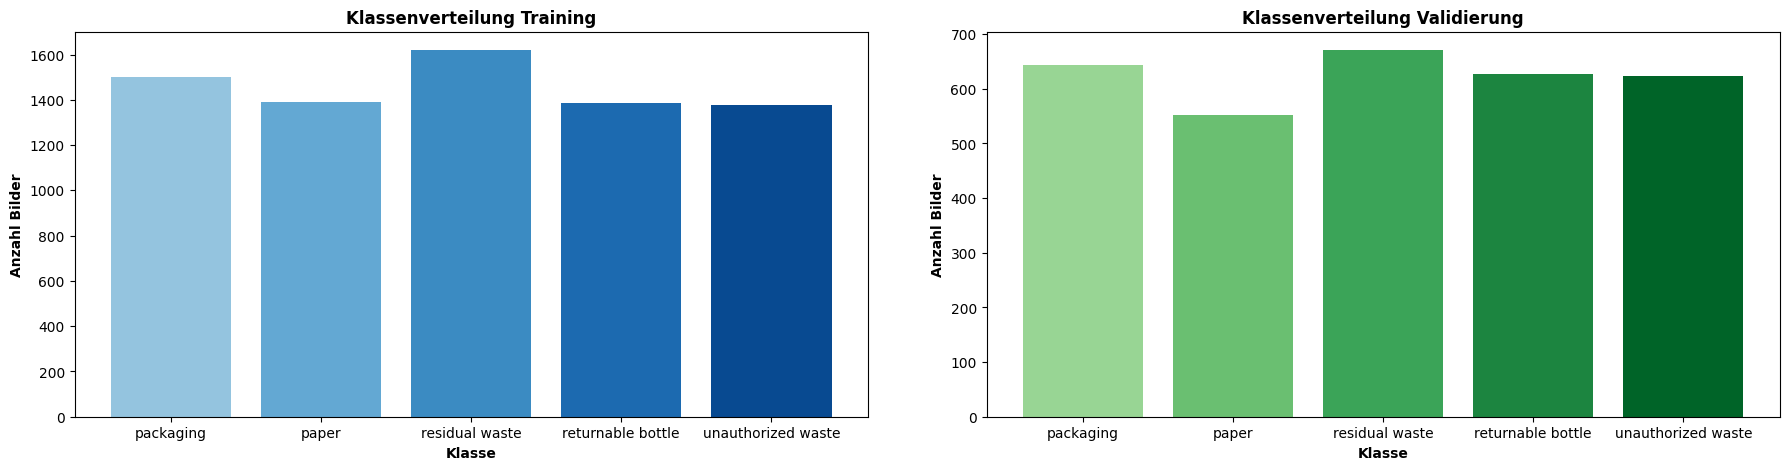

In [46]:
# --- Train ---
train_dist = count_classes_subset(extern_train_loader.dataset, extern_full_dataset.classes)

# --- Validation ---
val_dist = count_classes_subset(extern_val_loader.dataset, extern_full_dataset.classes)

# --- Plot ---
print_train_val_distribution(train_dist, val_dist, extern_full_dataset.classes)

Zählen und Visualisieren der Custom-Subsets.

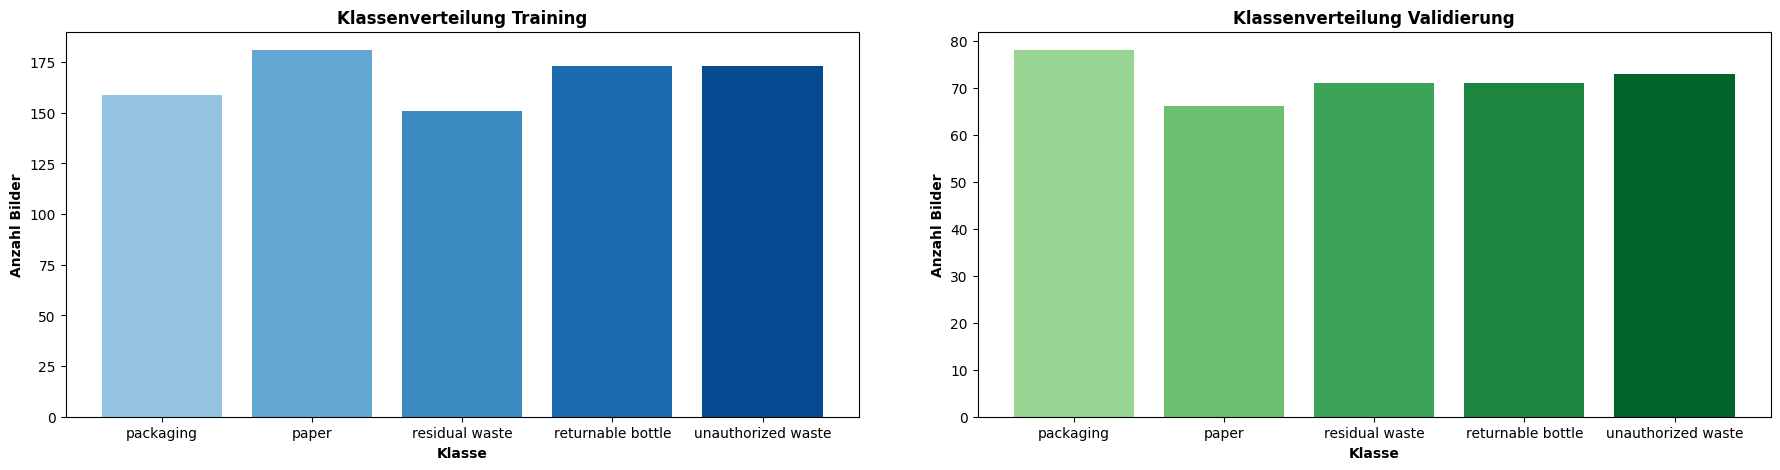

In [47]:
# --- Train ---
custom_train_dist = count_classes_subset(custom_train_loader.dataset, custom_full_dataset.classes)

# --- Validation ---
custom_val_dist = count_classes_subset(custom_val_loader.dataset, custom_full_dataset.classes)

# --- Plot ---
print_train_val_distribution(custom_train_dist, custom_val_dist, custom_full_dataset.classes)

Zählen und Visualisieren der All-Subsets.

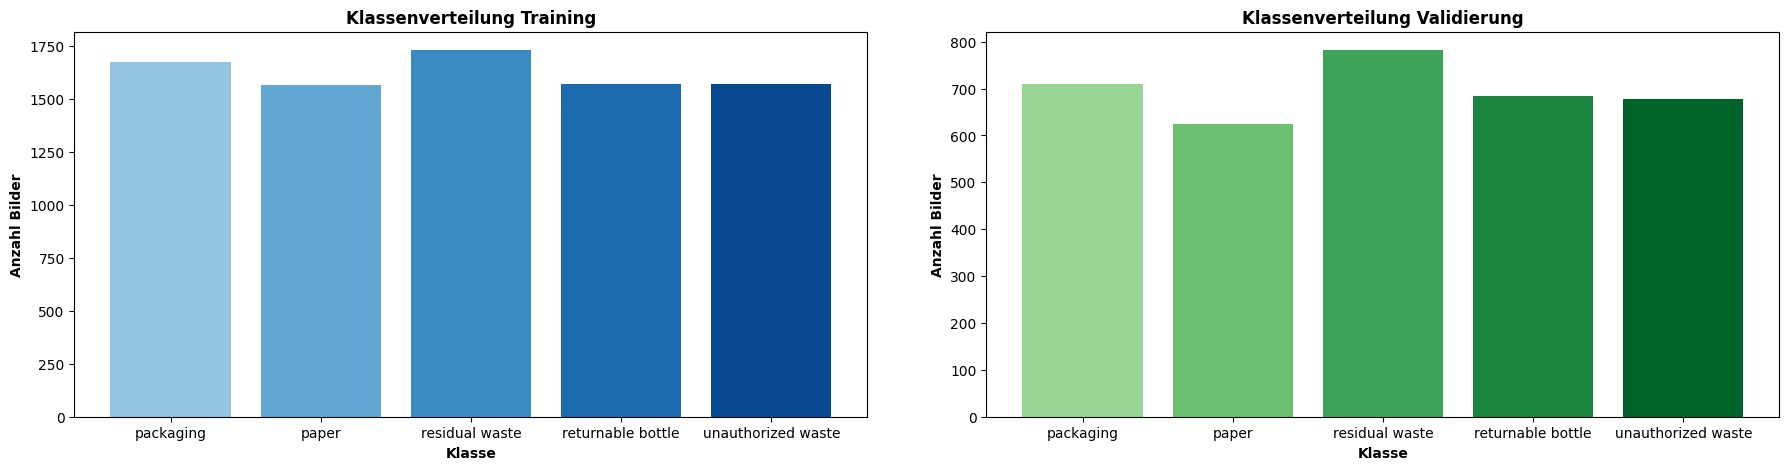

In [48]:
# --- Train ---
all_train_dist = count_classes_subset(all_train_loader.dataset, all_full_dataset.classes)

# --- Validation ---
all_val_dist = count_classes_subset(all_val_loader.dataset, all_full_dataset.classes)

# --- Plot ---
print_train_val_distribution(all_train_dist, all_val_dist, all_full_dataset.classes)

Hier werden zufällige Bilder aus einem Datenset inklusive ihrer Klassennamen visualisiert.

In [55]:
def show_random_samples(dataset): 
    figure = plt.figure(figsize=(12, 10))
    cols, rows = 6, 1
    class_names = extern_full_dataset.classes  

    for i in range(1, rows * cols + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]

        img = img.permute(1, 2, 0)
        class_name = class_names[int(label)]

        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.title(class_name)
        plt.imshow(img)

    plt.tight_layout()
    plt.show()

Anzeige zufälliger Bilder des Extern-Datasets

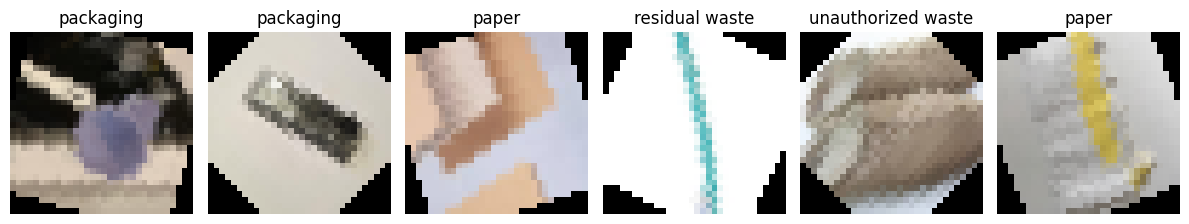

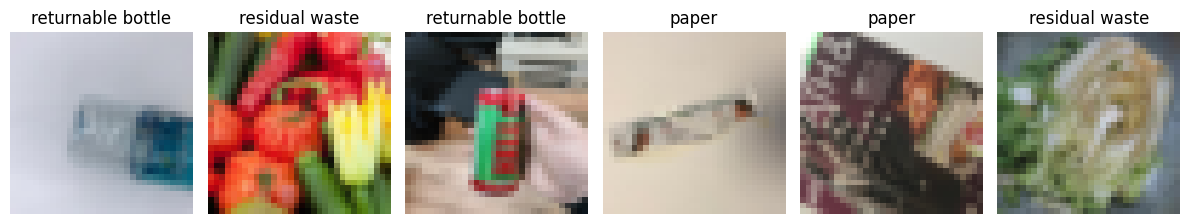

In [56]:
# --- Train ---
show_random_samples(extern_train_loader.dataset)

# --- Validation ---
show_random_samples(extern_val_loader.dataset)


Anzeige zufälliger Bilder des Custom-Datasets

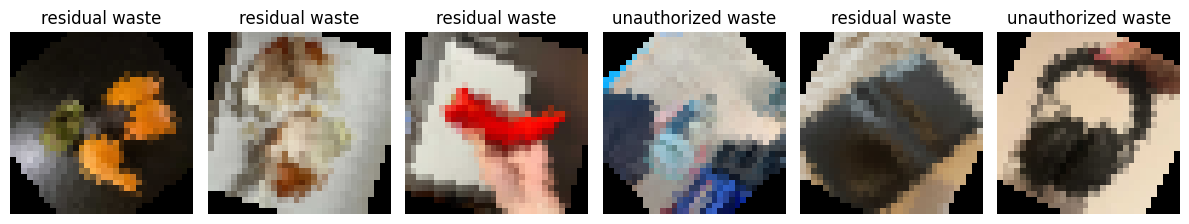

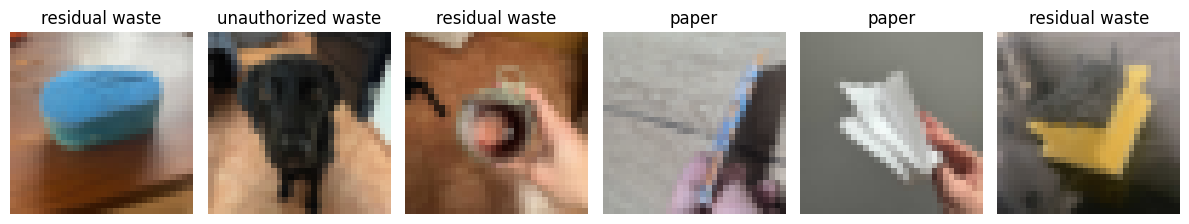

In [27]:
show_random_samples(custom_train_loader.dataset)
show_random_samples(custom_val_loader.dataset)

Anzeige zufälliger Bilder des All-Datasets

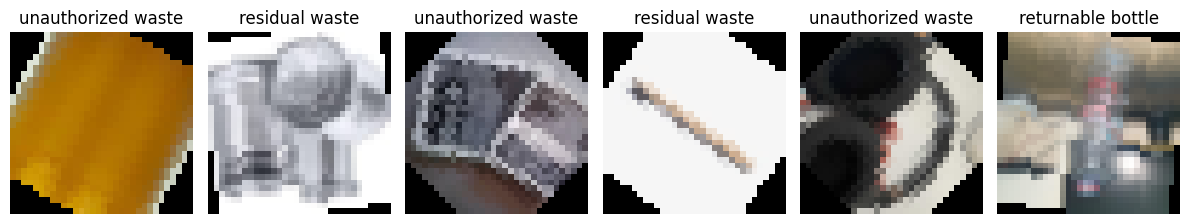

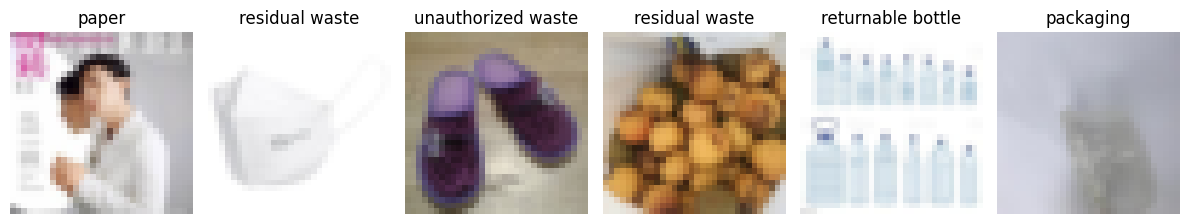

In [28]:
show_random_samples(all_train_loader.dataset)
show_random_samples(all_val_loader.dataset)

### 4. Modellarchitekturen

1. MLP 
2. CNN 
2. Transfer Learning: VGG16 & ResNet50 <br>
    2.1. From scratch <br>
    2.2. Pretrained<br>
    2.3. Fine Tune <br>

#### 4.1. Multi Layer Perceptron - MLP

Die Klasse `MLP` implementiert ein **Multilayer Perceptron (MLP)** zur Klassifikation von Bilddaten.
Das Modell besteht aus einer vollständig verbundenen Hidden-Schicht mit Dropout-Regularisierung
sowie einer Ausgabeschicht zur Vorhersage der Klassenwahrscheinlichkeiten.

Die Implementierung basiert auf **PyTorch** und erbt von `torch.nn.Module`.

---

##### Zweck

Das MLP dient als **einfaches neuronales Basismodell**, um Bilddaten nach vorheriger
Serialisierung (Flattening) zu klassifizieren.  
Es eignet sich insbesondere:
- als Vergleichsmodell zu komplexeren Architekturen (z. B. CNNs),
- für Experimente mit Fully-Connected-Netzen,
- für kleinere Datensätze oder als Lernbeispiel.

---

In [29]:
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.d1 = nn.Linear(channel * image_size * image_size, config.hidden_dim)
        self.dropout = nn.Dropout(p=config.dropout)
        self.d2 = nn.Linear(config.hidden_dim, extern_class_count)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1) #serialize 3dim input

        x = self.d1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        raw_scores = self.d2(x)
        # output_predictions = torch.softmax(raw_scores , dim=1)   

        return raw_scores 

#### 4.2. Convolutional Neural Network - CNN

Die Klasse `CNN` implementiert ein **Convolutional Neural Network (CNN)** zur Bildklassifikation.
Das Modell nutzt mehrere Faltungs- und Pooling-Schichten zur Extraktion räumlicher Merkmale
sowie vollständig verbundene Schichten zur Klassifikation.

Die Implementierung basiert auf **PyTorch** und erbt von `torch.nn.Module`.

---

#### Zweck

Das CNN ist für die **automatische Merkmalsextraktion aus Bilddaten** konzipiert.
Im Gegensatz zu einem MLP nutzt es die räumliche Struktur der Bilder und eignet sich daher
besonders gut für visuelle Klassifikationsaufgaben.

Typische Einsatzbereiche:
- Bildklassifikation
- Vergleich mit einfacheren Baseline-Modellen (z. B. MLP)
- Experimente mit Regularisierung (Dropout, Batch Normalization)

---

In [30]:
class CNN(nn.Module):
    def __init__(self, config):
        super(CNN, self).__init__()
        self.drop=nn.Dropout2d(config.dropout)
        self.dropfc=nn.Dropout(config.dropout)
        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512*2*2, config.hidden_dim_1)
        self.fc2 = nn.Linear(config.hidden_dim_1, extern_class_count)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.drop(self.conv1(x)))))
        x = self.pool(F.relu(self.bn2(self.drop(self.conv2(x)))))
        x = self.pool(F.relu(self.bn3(self.drop(self.conv3(x)))))
        x = self.pool(F.relu(self.bn4(self.drop(self.conv4(x)))))
        x = x.view(-1, 512*2*2)
        x = F.relu(self.dropfc(self.fc1(x)))
        x = self.fc2(x)
        return x

#### 4.3. Transfer Learning 

##### 4.3.1. VGG16 Modell


Die Klasse `VGG16` implementiert ein **auf VGG16 basierendes Convolutional Neural Network**
für die Bildklassifikation. Je nach Konfiguration kann das Modell
- **von Grund auf neu trainiert**,
- **als eingefrorenes, vortrainiertes Modell genutzt**
- oder **feinjustiert (Fine-Tuning)** werden.

Die Implementierung nutzt das vortrainierte **VGG16-Modell aus `torchvision.models`**
und passt die Architektur an die Zielklassen des Datensatzes an.

---

#### Zweck

Dieses Modell dient zur **leistungsstarken Bildklassifikation** unter Nutzung von
**Transfer Learning**. Durch die Wiederverwendung vortrainierter Gewichte
(konzipiert für ImageNet) kann auch bei kleineren Datensätzen eine hohe
Generalisierungsleistung erreicht werden.

Typische Einsatzszenarien:
- Transfer Learning
- Fine-Tuning vortrainierter CNNs
- Vergleich mit selbst implementierten CNN-Architekturen

---

In [31]:
class VGG16(nn.Module):
    def __init__(self, config):
        super(VGG16, self).__init__()
        self.config = config
        
        if config.model_subtype == "TRAIN_FROM_SCRATCH":
            self.model = models.vgg16(pretrained=False)
            for param in self.model.parameters():
                param.requires_grad = True
        elif config.model_subtype == "TRAIN_PRETRAINED":
            self.model = models.vgg16(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = False
        elif config.model_subtype == "TRAIN_FINETUNE":
            self.model = models.vgg16(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            raise ValueError(f"Unknown model_subtype {config.model_subtype}")
        
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, config.hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, extern_class_count)
        )

    def forward(self, x):
        return self.model(x)


##### 4.3.2. ResNet50

Die Klasse `ResNet50` implementiert ein **auf ResNet50 basierendes Deep Convolutional Neural Network**
zur Bildklassifikation. Ähnlich zur `VGG16`-Klasse nutzt dieses Modell **Transfer Learning**
und erlaubt verschiedene Trainingsstrategien, unterscheidet sich jedoch grundlegend in seiner
Architektur durch die Verwendung von **Residual Connections**.

Die Implementierung basiert auf dem vortrainierten **ResNet50-Modell aus `torchvision.models`**.

---

#### Zweck

Das ResNet50-Modell wird eingesetzt, um:
- die Leistungsfähigkeit moderner, tiefer CNN-Architekturen zu evaluieren,
- **VGG16 und ResNet50 direkt miteinander zu vergleichen**,
- die Auswirkungen von Architekturentscheidungen (Tiefe, Residual Connections)
  auf Trainingsstabilität und Generalisierung zu analysieren.

Insbesondere steht hier der **Vergleich zwischen klassischen CNNs (VGG16) und Residual Networks**
im Fokus der Untersuchung.

---

In [32]:
class ResNet50(nn.Module):
    def __init__(self, config):
        super(ResNet50, self).__init__()
        self.config = config
        
        if config.model_subtype == "TRAIN_FROM_SCRATCH":
            self.model = models.resnet50(pretrained=False) 
            for param in self.model.parameters():
                param.requires_grad = True

        elif config.model_subtype == "TRAIN_PRETRAINED":
            self.model = models.resnet50(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = False

        elif config.model_subtype == "TRAIN_FINETUNE":
            self.model = models.resnet50(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            raise ValueError(f"Unknown model_subtype {config.model_subtype}")

        num_ftrs = self.model.fc.in_features 

        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs, config.hidden_dim), 
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, extern_class_count)
        )

    def forward(self, x):
        return self.model(x)

### 5. Trainieren & Testen

#### 5.1. Funktionen

### Funktion `get_model`

Die Funktion `get_model` ist eine **zentrale Factory-Funktion** zur Initialisierung
von Modellen, Optimierern und Verlustfunktionen.
Sie kapselt die gesamte Modellkonfiguration und stellt sicher, dass
alle Experimente konsistent und vergleichbar durchgeführt werden.

---

#### Zweck

Diese Funktion dient dazu:
- unterschiedliche Modellarchitekturen **einheitlich zu initialisieren**,
- passende Optimierer abhängig vom Modelltyp zu wählen,
- eine gemeinsame Verlustfunktion zu definieren,
- die Modelle automatisch auf das Zielgerät (CPU/GPU) zu verschieben,
- eine übersichtliche Modellzusammenfassung auszugeben.

Dadurch wird ein **fairer Vergleich zwischen MLP, CNN, VGG16 und ResNet50**
ermöglicht, ohne Code-Duplikation oder inkonsistente Trainingspipelines.

---

In [33]:
def get_model(config):
    print(config)
    if config.model_type == "MLP":
        model = MLP(config) 
        optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

    elif config.model_type == "CNN":
        model = CNN(config) 
        optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

    elif config.model_type == "TRANSFER_VGG":
        model = VGG16(config);  
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

    elif config.model_type == "TRANSFER_RN":
        model = ResNet50(config);  
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()
    else:
        raise ValueError(f"Unknown model_type {config.model_type}")
    
    model = model.to(device)
    summary(model, input_size=(channel, image_size, image_size))

    return model, optimizer, loss_fn

#### Trainings Funktionen

In [34]:
def get_accuracy(output, target, batch_size):
    prediction=torch.max(output, 1)[1].view(target.size())
    corrects = (prediction.data == target.data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

In [35]:
def train_step(model, config, optimizer, loss_fn, train_loader): 
    loss_value = 0.0
    accuracy_value = 0.0


    for i, (images, labels) in enumerate(train_loader):
        model.train()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_value += loss.detach().item()
        accuracy_value += get_accuracy(outputs, labels, config.batch_size)

    loss_avg = loss_value / i
    accuracy_avg = accuracy_value / i

    return loss_avg, accuracy_avg

        

In [36]:
def val_step(model, config, loss_fn, val_loader):
    loss_value = 0.0
    accuracy_value = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            model.eval()

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            loss_value += loss.detach().item()
            accuracy_value += get_accuracy(outputs, labels, config.batch_size)

    loss_avg = loss_value / i
    accuracy_avg = accuracy_value / i

    return loss_avg, accuracy_avg

In [37]:
def print_results(num_epochs, train_accuracy, val_accuracy, model, val_loader, full_dataset):

    # print training and validation accuracy plot
    plt.figure(figsize=(12,8))
    plt.plot(range(num_epochs),train_accuracy,"r",label="training accuracy")
    plt.plot(range(num_epochs),val_accuracy,"b",label="validation accuracy")
    plt.xlabel("epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # evaluate on validation set
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # print classification report 
    print(classification_report(y_true, y_pred))

    # print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.xlabel('Vorhergesagte Klasse (Prediction)')
    plt.ylabel('Wahre Klasse (True Label)')
    plt.title('Confusion Matrix: Was wird womit verwechselt?')
    plt.show()

In [38]:
def run_training_loop(name, model, config, optimizer, loss_fn, train_loader, val_loader, full_dataset ):
    print(f"Start training for {name} with {config.epochs} epochs...") 
    
    model = model.to(device) 

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(config.epochs):
        
        train_loss_avg, train_accuracy_avg = train_step(model, config, optimizer, loss_fn, train_loader)
        val_loss_avg, val_accuracy_avg = val_step(model, config, loss_fn, val_loader)

        history['train_loss'].append(train_loss_avg)
        history['train_accuracy'].append(train_accuracy_avg)
        history['val_loss'].append(val_loss_avg)
        history['val_accuracy'].append(val_accuracy_avg)

        print(f"Epoch [{epoch+1}/{config.epochs}], "
              f"Train Loss: {train_loss_avg:.4f}, Train Acc: {train_accuracy_avg:.2f}%, "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy_avg:.2f}%")
        
    
        wandb.log({
            "train_loss": train_loss_avg,
            "train_accuracy": train_accuracy_avg,
            "val_loss": val_loss_avg,
            "val_accuracy": val_accuracy_avg
        })
    
    print_results(config.epochs, history['train_accuracy'], history['val_accuracy'], model, val_loader , full_dataset)

In [39]:
def extern_model_pipeline(name, config=None):
    
    with wandb.init(project=WANDB_PROJECT, config=config):
        config = wandb.config
        print(f"Running model pipeline: {name}, with config: {config}")

        model, optimizer, loss_fn = get_model(config)

        run_training_loop(name, model, config, optimizer, loss_fn, extern_train_loader, extern_val_loader, extern_full_dataset)

#### 5.2. Pipelines

Running model pipeline: MLP, with config: {'model_type': 'MLP', 'batch_size': 16, 'learning_rate': 0.1, 'epochs': 30, 'hidden_dim': 512, 'dropout': 0.2}
{'model_type': 'MLP', 'batch_size': 16, 'learning_rate': 0.1, 'epochs': 30, 'hidden_dim': 512, 'dropout': 0.2}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
           Dropout-2                  [-1, 512]               0
            Linear-3                    [-1, 5]           2,565
Total params: 1,575,941
Trainable params: 1,575,941
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.01
Estimated Total Size (MB): 6.03
----------------------------------------------------------------
Start training for MLP with 30 epochs...
Epoch [1/30], Train Loss: 1.6178, Train Acc: 23.86%, 

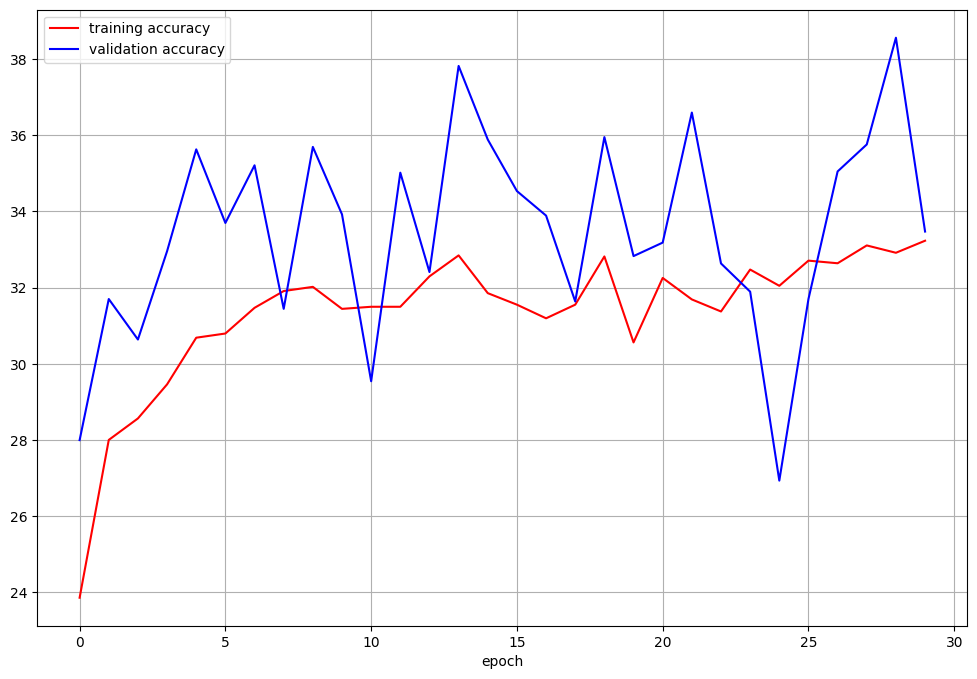

              precision    recall  f1-score   support

           0       0.87      0.12      0.21       661
           1       0.27      0.06      0.10       565
           2       0.42      0.24      0.31       721
           3       0.25      0.92      0.40       580
           4       0.55      0.37      0.44       591

    accuracy                           0.33      3118
   macro avg       0.47      0.34      0.29      3118
weighted avg       0.48      0.33      0.29      3118



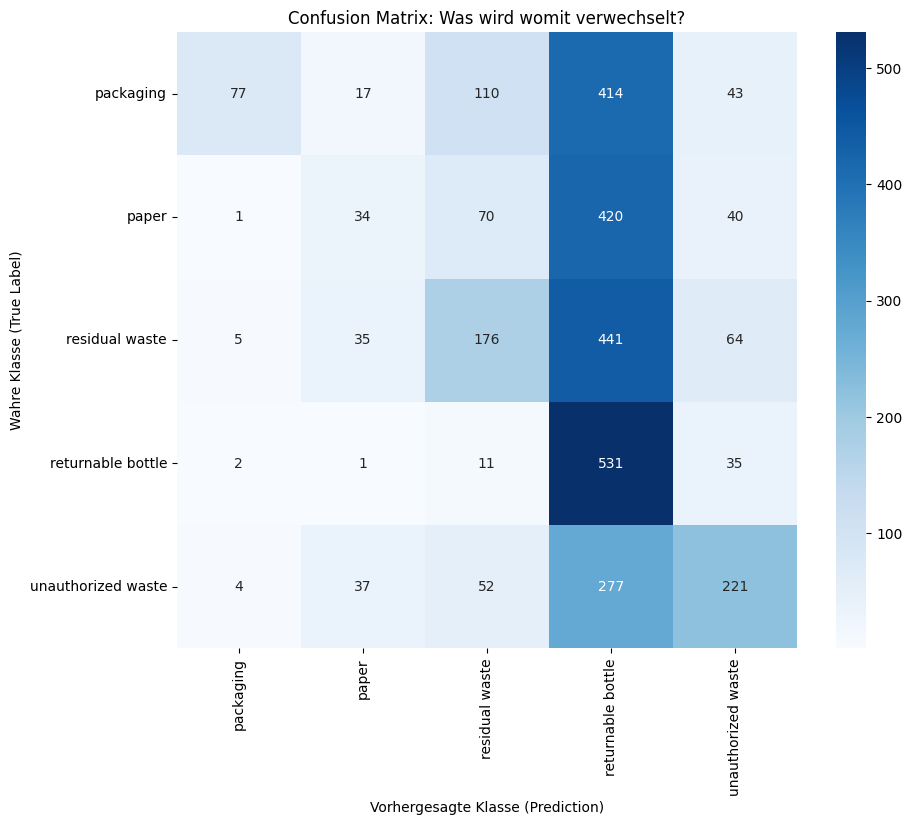

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇█▇▇▆▇█▆▇▇▇▇▇█████
train_loss,█▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▄▃▅▆▅▆▄▆▅▃▆▄█▆▆▅▄▆▅▅▇▄▄▁▄▆▆█▅
val_loss,▅▄▄▄▄▃▄▇▃▄▄▃▃▂█▃▃▇▂▃▄▃▃▄▄▃▃▃▁▃
train_accuracy,33.23238
train_loss,1.50333
val_accuracy,33.47294
val_loss,1.48599


In [40]:
extern_model_pipeline("MLP", config_mlp)

In [41]:
extern_model_pipeline("CNN", config_cnn)

Running model pipeline: CNN, with config: {'model_type': 'CNN', 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 30, 'hidden_dim_1': 1024, 'dropout': 0.2}
{'model_type': 'CNN', 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 30, 'hidden_dim_1': 1024, 'dropout': 0.2}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         Dropout2d-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         Dropout2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
        Dropout2d-10   

Traceback (most recent call last):
  File "C:\Users\julse\AppData\Local\Temp\ipykernel_8336\721318084.py", line 9, in extern_model_pipeline
    run_training_loop(name, model, config, optimizer, loss_fn, extern_train_loader, extern_val_loader, extern_full_dataset)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\julse\AppData\Local\Temp\ipykernel_8336\1996344848.py", line 16, in run_training_loop
    val_loss_avg, val_accuracy_avg = val_step(model, config, loss_fn, val_loader)
                                     ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\julse\AppData\Local\Temp\ipykernel_8336\4134107495.py", line 6, in val_step
    for i, (images, labels) in enumerate(val_loader):
                               ~~~~~~~~~^^^^^^^^^^^^
  File "C:\Users\julse\AppData\Roaming\Python\Python314\site-packages\torch\utils\data\dataloader.py", line 494, in __iter__
    return self._get

KeyboardInterrupt: 

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FROM_SCRATCH', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

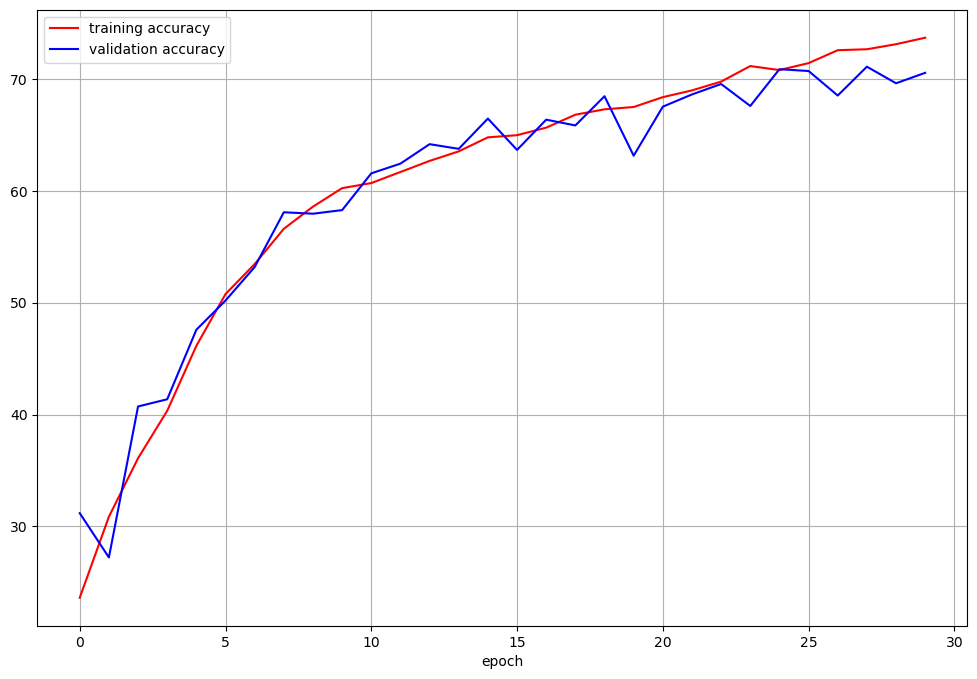

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       661
           1       0.71      0.70      0.70       565
           2       0.63      0.76      0.69       721
           3       0.70      0.90      0.79       580
           4       0.78      0.56      0.66       591

    accuracy                           0.70      3118
   macro avg       0.72      0.70      0.70      3118
weighted avg       0.71      0.70      0.70      3118



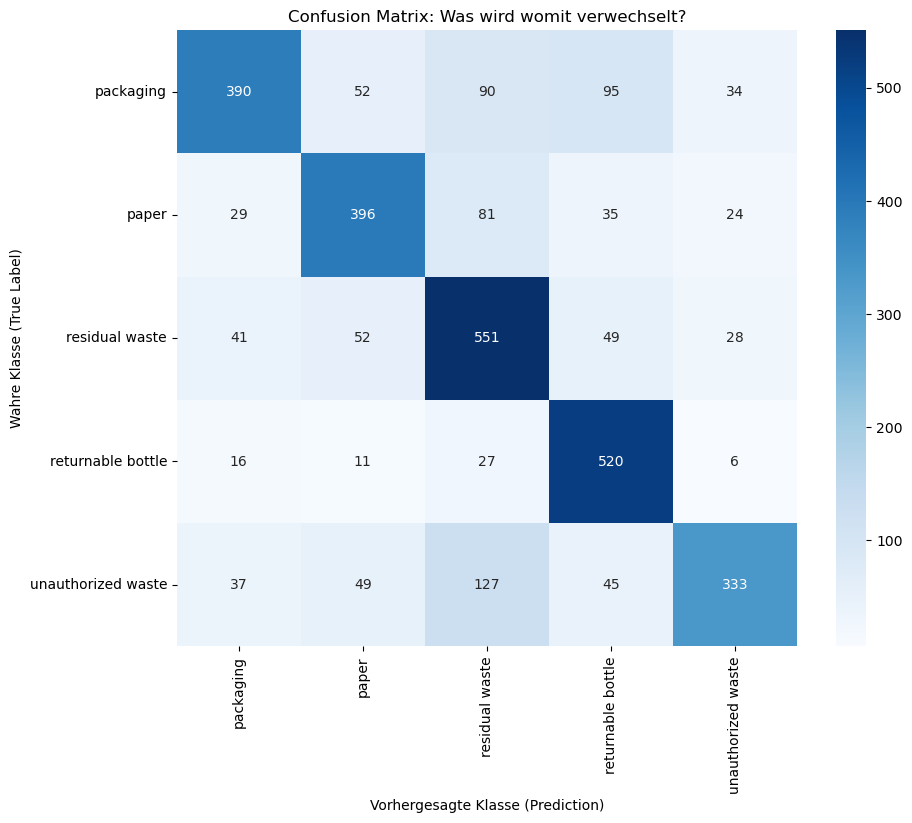

train_accuracy,▁▂▃▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇██▇██████
val_loss,██▇▆▆▅▇▄▄▄▃▃▃▃▂▃▂▂▂▃▂▂▁▂▁▁▂▁▁▂
train_accuracy,73.69218
train_loss,0.722
val_accuracy,70.55412
val_loss,0.86087


In [ ]:
extern_model_pipeline("Transfer Learning - From Scratch", config_transfer_vgg["scratch"])

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_PRETRAINED', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

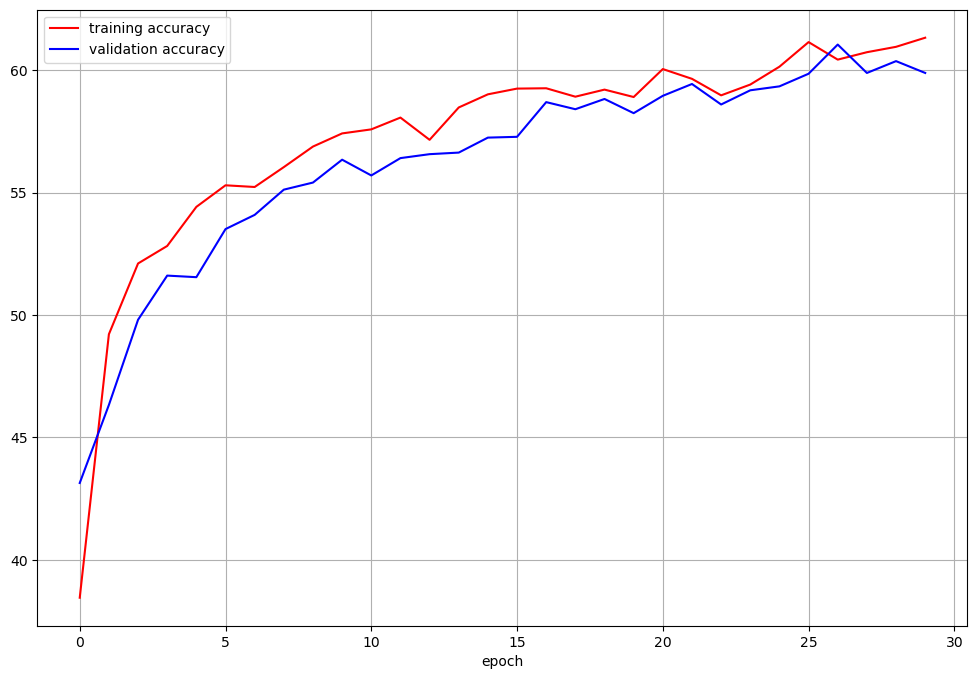

              precision    recall  f1-score   support

           0       0.62      0.46      0.52       661
           1       0.61      0.60      0.60       565
           2       0.67      0.66      0.66       721
           3       0.63      0.63      0.63       580
           4       0.49      0.64      0.55       591

    accuracy                           0.60      3118
   macro avg       0.60      0.60      0.59      3118
weighted avg       0.60      0.60      0.60      3118



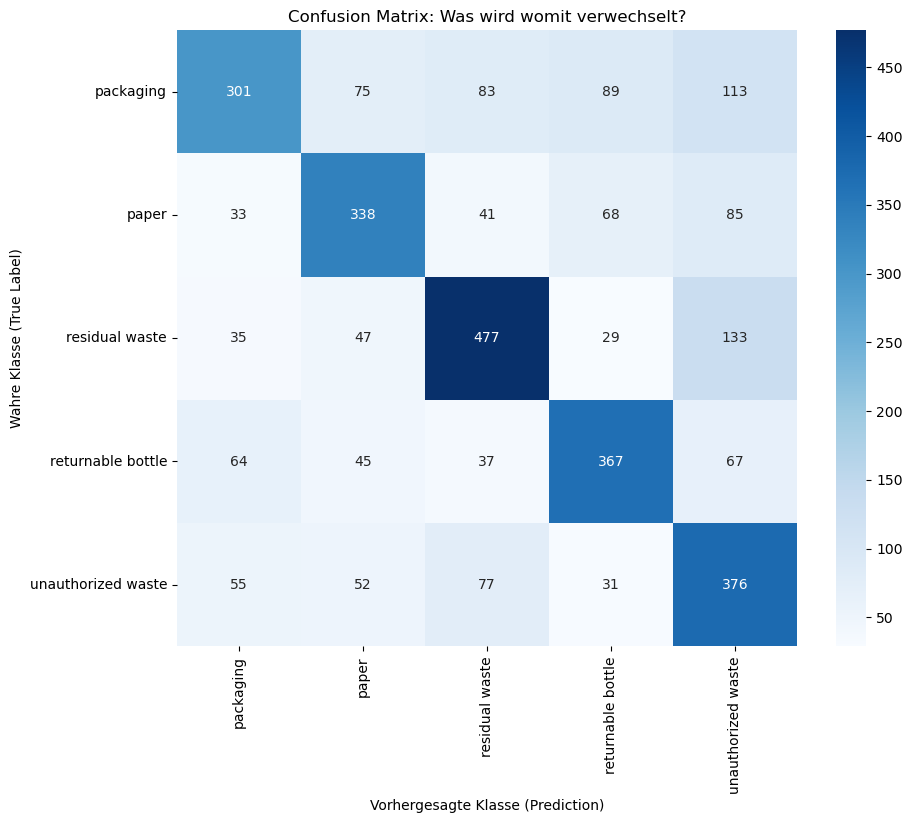

train_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██████
train_loss,█▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
val_loss,█▆▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_accuracy,61.32985
train_loss,1.01074
val_accuracy,59.89046
val_loss,1.03941


In [ ]:
extern_model_pipeline("Transfer Learning - Pretrained", config_transfer_vgg["pretrained"])

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

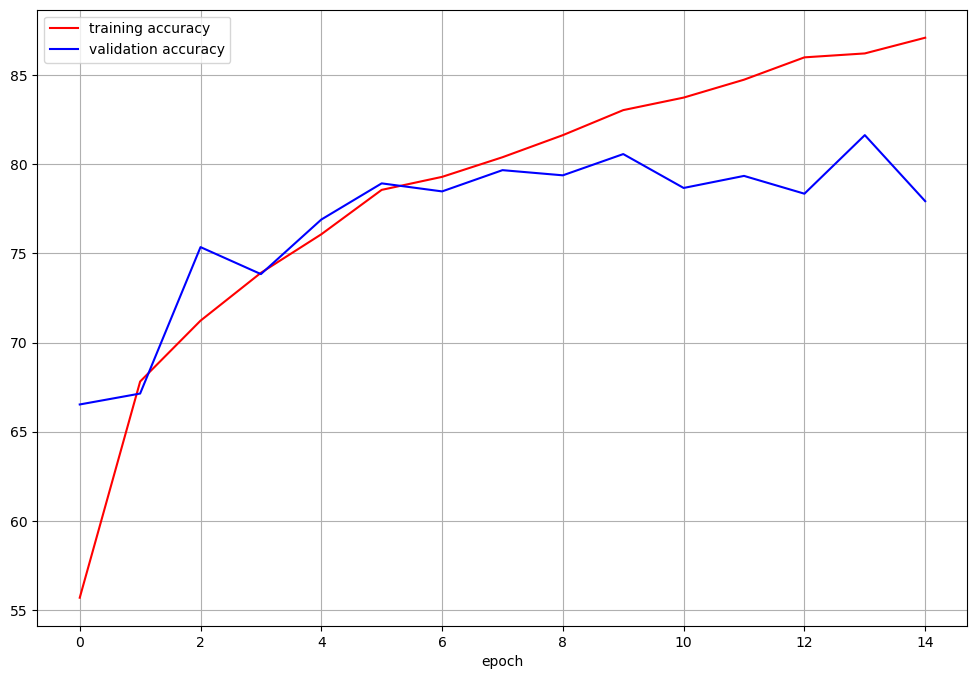

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       661
           1       0.92      0.68      0.78       565
           2       0.87      0.74      0.80       721
           3       0.69      0.95      0.80       580
           4       0.68      0.82      0.74       591

    accuracy                           0.78      3118
   macro avg       0.79      0.78      0.78      3118
weighted avg       0.80      0.78      0.78      3118



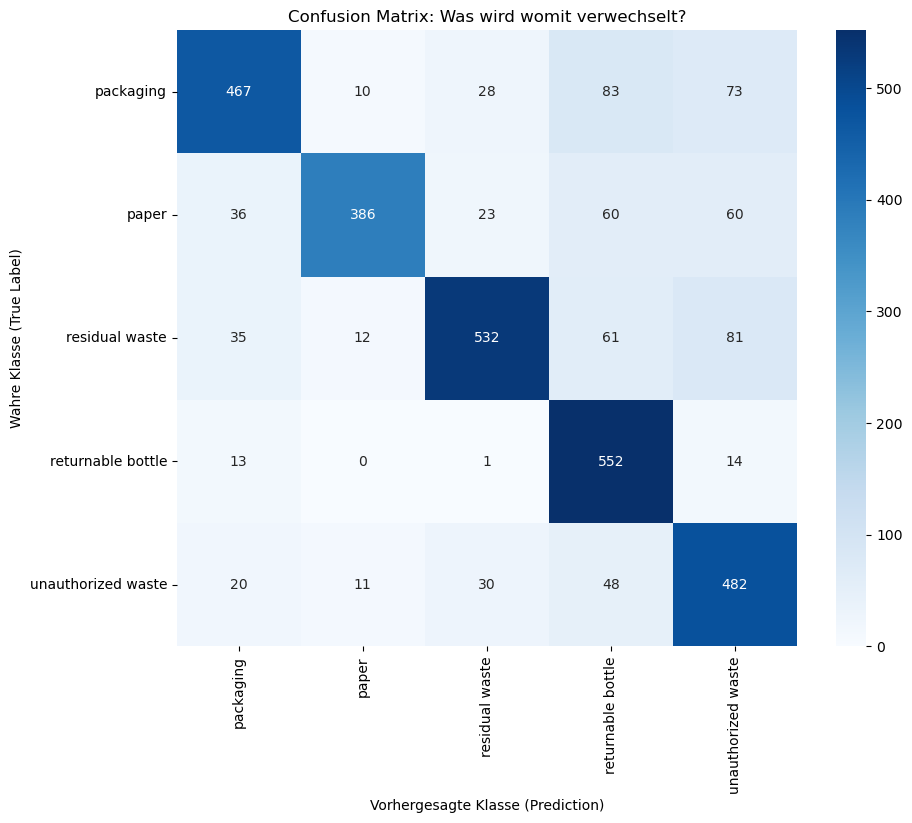

train_accuracy,▁▄▄▅▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▁▅▄▆▇▇▇▇█▇▇▆█▆
val_loss,██▄▆▂▂▂▁▁▁▂▂▃▁▄
train_accuracy,87.10077
train_loss,0.3729
val_accuracy,77.9317
val_loss,0.74556


In [ ]:

extern_model_pipeline("Transfer Learning - Finetune", config_transfer_vgg["finetune"])

In [ ]:
def custom_model_pipeline(name, config):
    
    with wandb.init(project=WANDB_PROJECT, config=config):
        config = wandb.config

        model, optimizer, loss_fn = get_model(config)

        run_training_loop(name, model, config, optimizer, loss_fn, custom_train_loader, custom_val_loader, custom_full_dataset)

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

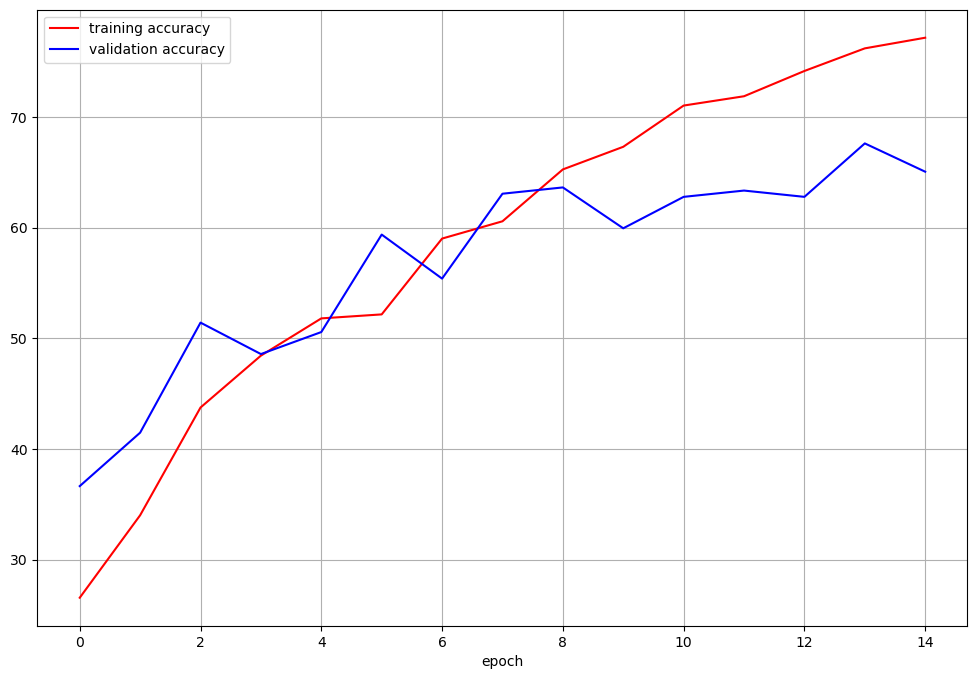

              precision    recall  f1-score   support

           0       0.47      0.64      0.54        72
           1       0.64      0.64      0.64        66
           2       0.76      0.68      0.72        79
           3       0.72      0.69      0.71        68
           4       0.67      0.54      0.60        74

    accuracy                           0.64       359
   macro avg       0.65      0.64      0.64       359
weighted avg       0.65      0.64      0.64       359



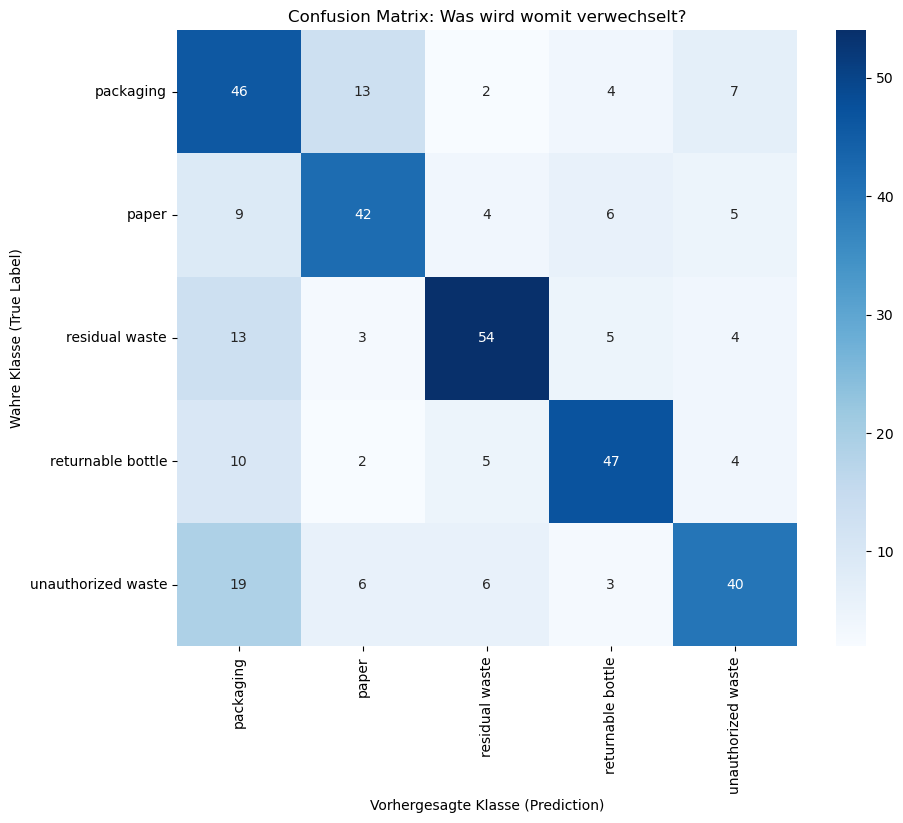

train_accuracy,▁▂▃▄▄▅▅▆▆▇▇▇███
train_loss,█▇▇▆▅▅▄▄▃▃▂▂▁▁▁
val_accuracy,▁▂▄▄▄▆▅▇▇▆▇▇▇█▇
val_loss,█▇▅▅▄▂▃▂▂▃▃▁▂▁▂
train_accuracy,77.16346
train_loss,0.67338
val_accuracy,65.05682
val_loss,1.09919


In [ ]:
custom_model_pipeline("Custom Transfer Learning - Finetune", config_transfer_vgg["finetune"])

## Alle Daten

In [ ]:
def all_model_pipeline(name, config):
    with wandb.init(project=WANDB_PROJECT, config=config):
        config = wandb.config

        model, optimizer, loss_fn = get_model(config)

        run_training_loop(name, model, config, optimizer, loss_fn, all_train_loader, all_val_loader, all_full_dataset)

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

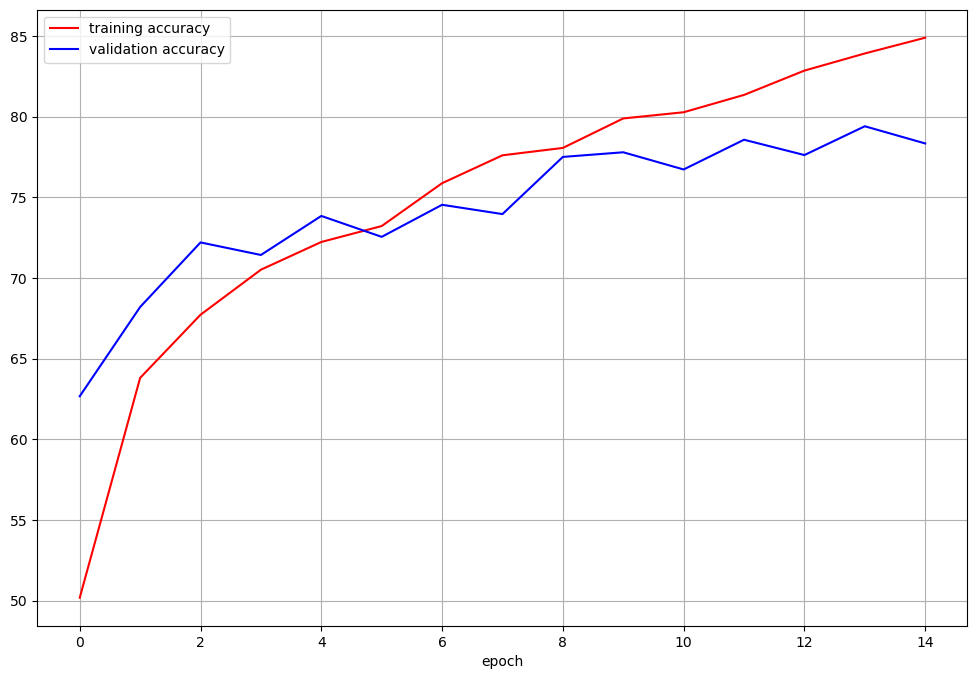

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       698
           1       0.69      0.93      0.79       650
           2       0.82      0.76      0.79       723
           3       0.84      0.89      0.87       709
           4       0.82      0.64      0.72       697

    accuracy                           0.78      3477
   macro avg       0.79      0.78      0.78      3477
weighted avg       0.79      0.78      0.78      3477



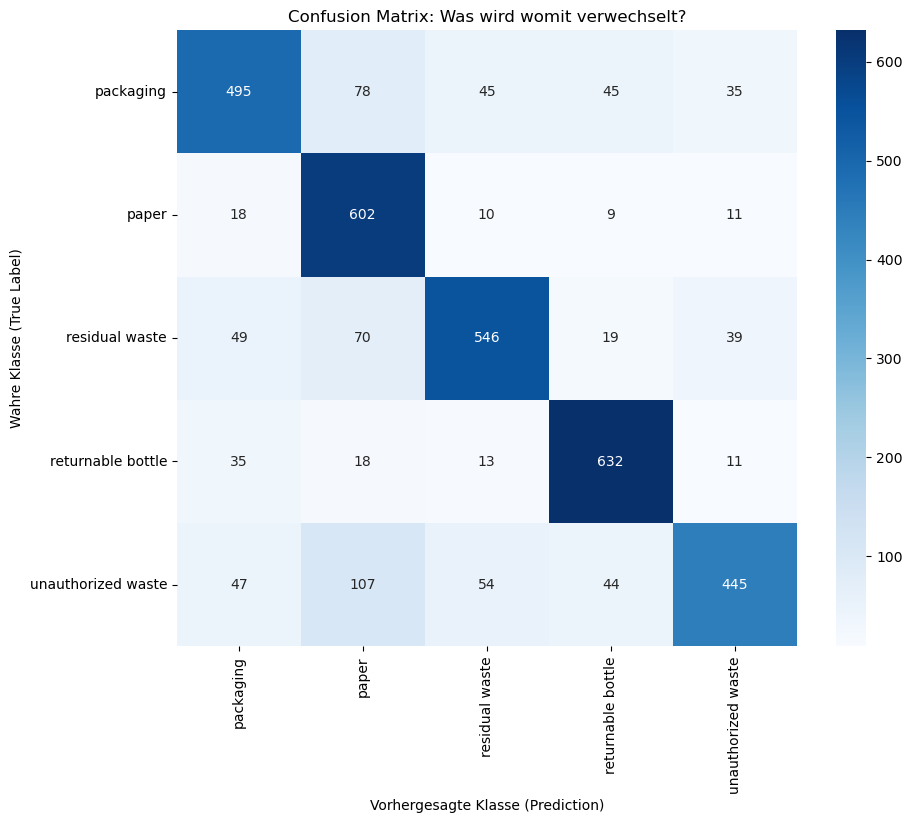

train_accuracy,▁▄▅▅▅▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▅▆▆▇▇▇█▇██
val_loss,█▅▄▄▃▃▃▃▁▂▂▁▁▁▂
train_accuracy,84.89377
train_loss,0.43116
val_accuracy,78.34101
val_loss,0.68784


In [ ]:
all_model_pipeline("Custom Transfer Learning - Finetune", config_transfer_vgg["finetune"])

## Finetuning with Custom Data and ResNet50

{'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Windows 11 Pro/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100.0%


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

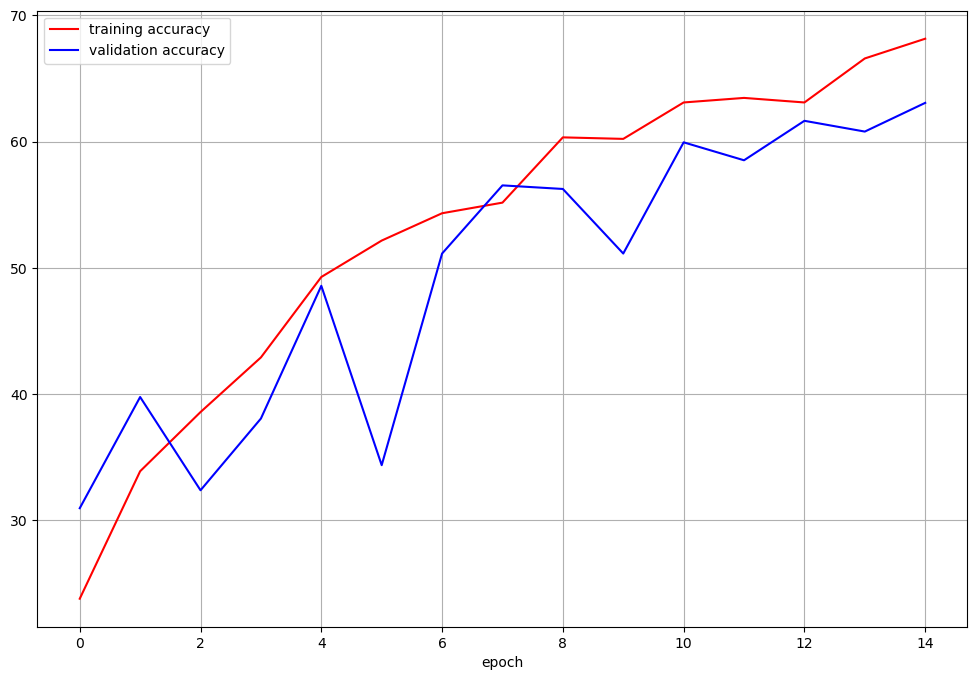

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        72
           1       0.55      0.47      0.51        66
           2       0.80      0.70      0.74        79
           3       0.65      0.66      0.66        68
           4       0.54      0.74      0.63        74

    accuracy                           0.62       359
   macro avg       0.62      0.61      0.61       359
weighted avg       0.63      0.62      0.62       359



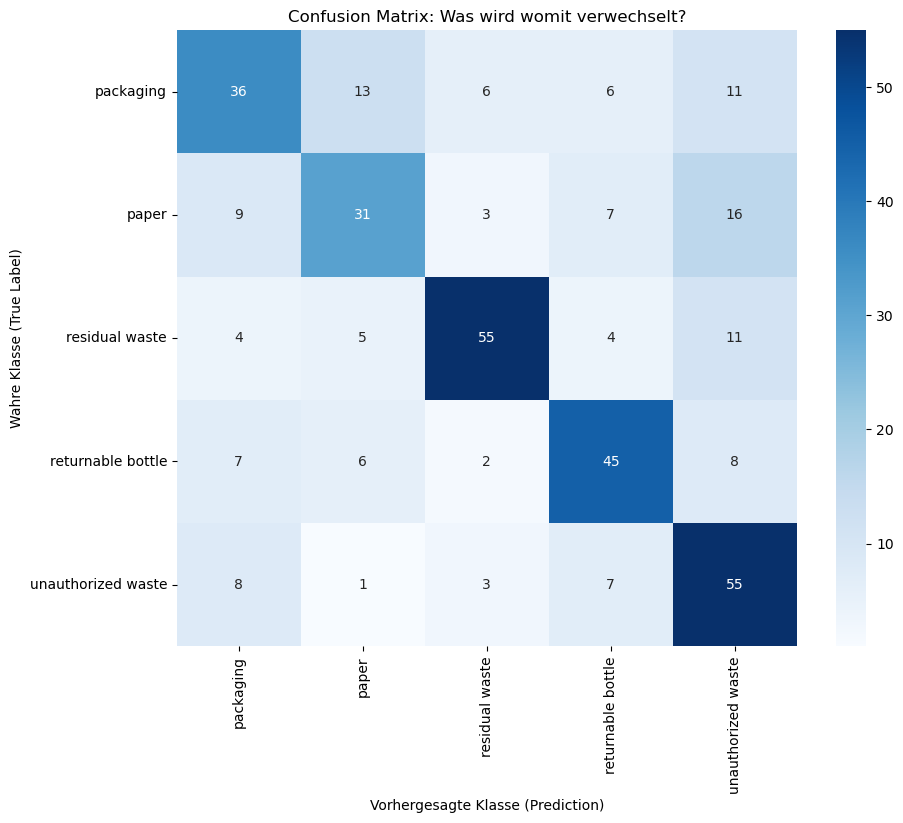

train_accuracy,▁▃▃▄▅▅▆▆▇▇▇▇▇██
train_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
val_accuracy,▁▃▁▃▅▂▅▇▇▅▇▇███
val_loss,▄▂█▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,68.14904
train_loss,0.87971
val_accuracy,63.06818
val_loss,1.05082


In [ ]:
custom_model_pipeline("Custom Data Transfer Learning with ResNet50", config_transfer_rn["finetune"])

{'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

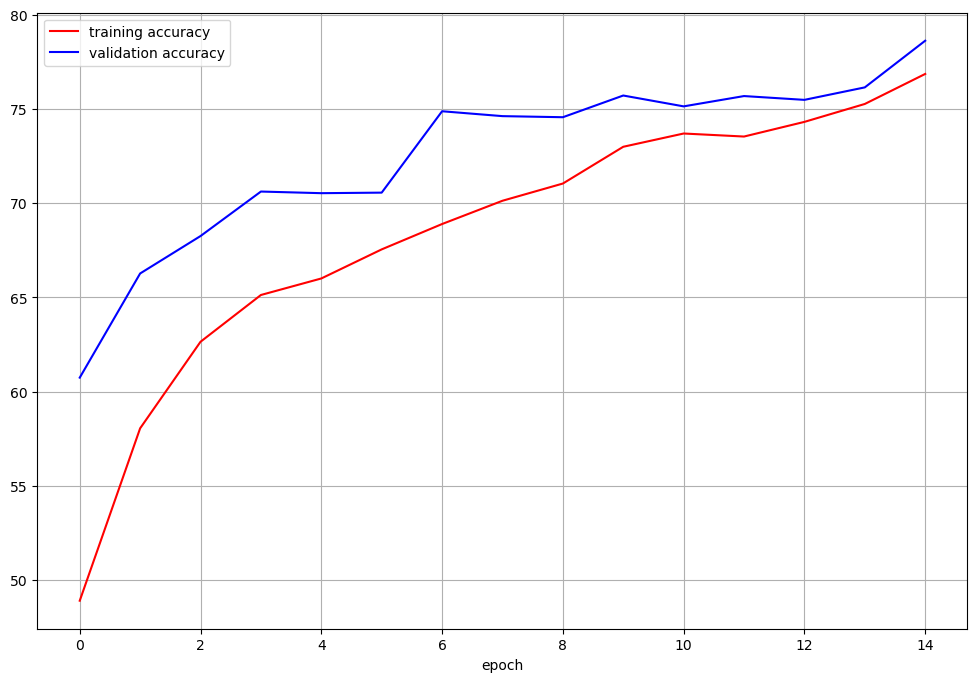

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       698
           1       0.84      0.79      0.82       650
           2       0.75      0.78      0.77       723
           3       0.86      0.89      0.87       709
           4       0.78      0.71      0.75       697

    accuracy                           0.79      3477
   macro avg       0.79      0.78      0.79      3477
weighted avg       0.79      0.79      0.79      3477



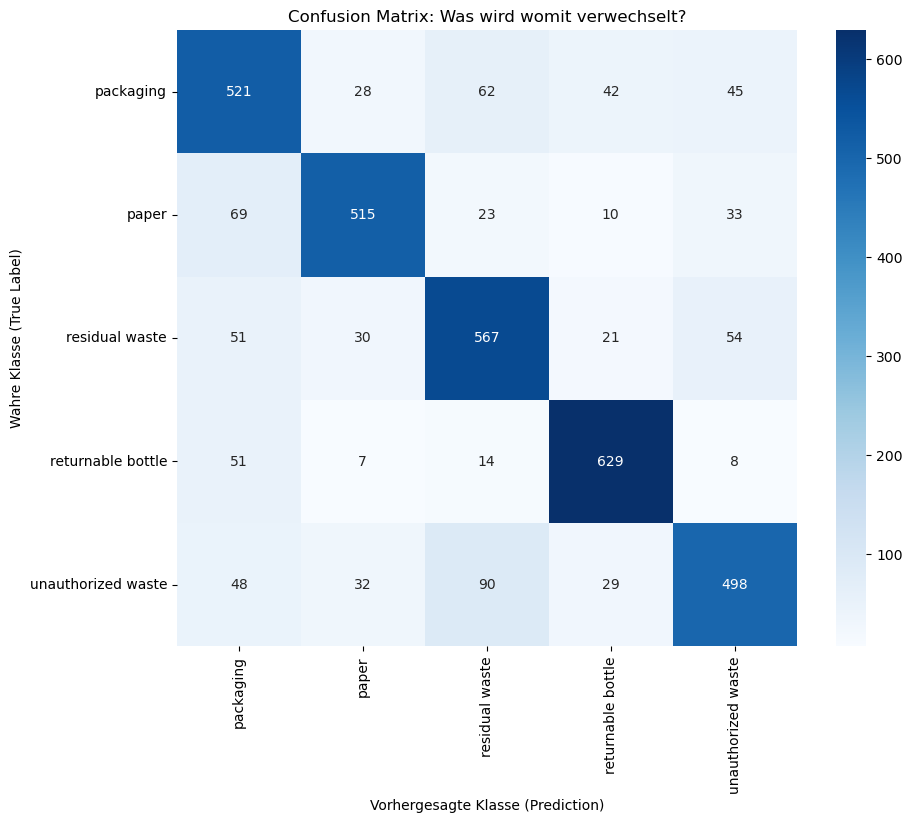

train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇██
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▄▅▅▅▇▆▆▇▇▇▇▇█
val_loss,█▆▅▅▄▄▃▂▂▂▂▂▂▂▁
train_accuracy,76.86512
train_loss,0.65246
val_accuracy,78.62903
val_loss,0.61453


In [ ]:
all_model_pipeline("All Data Transfer Learning with ResNet50", config_transfer_rn["finetune"])

Running model pipeline: Extern Data Transfer Learning with ResNet50, with config: {'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}
{'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

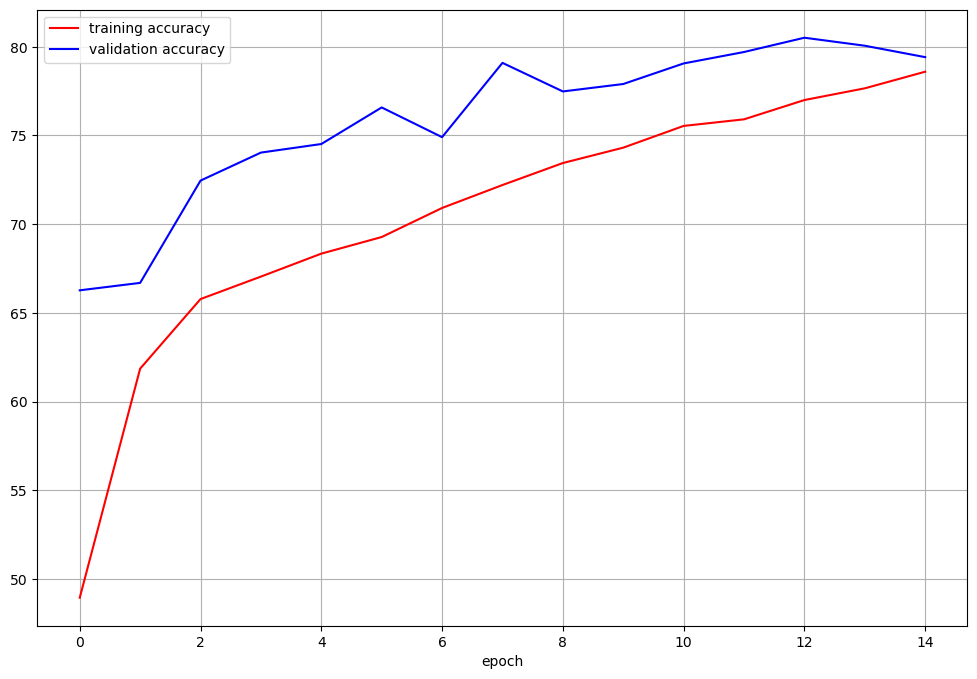

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       661
           1       0.83      0.82      0.82       565
           2       0.72      0.85      0.78       721
           3       0.92      0.83      0.87       580
           4       0.72      0.72      0.72       591

    accuracy                           0.79      3118
   macro avg       0.80      0.79      0.79      3118
weighted avg       0.80      0.79      0.79      3118



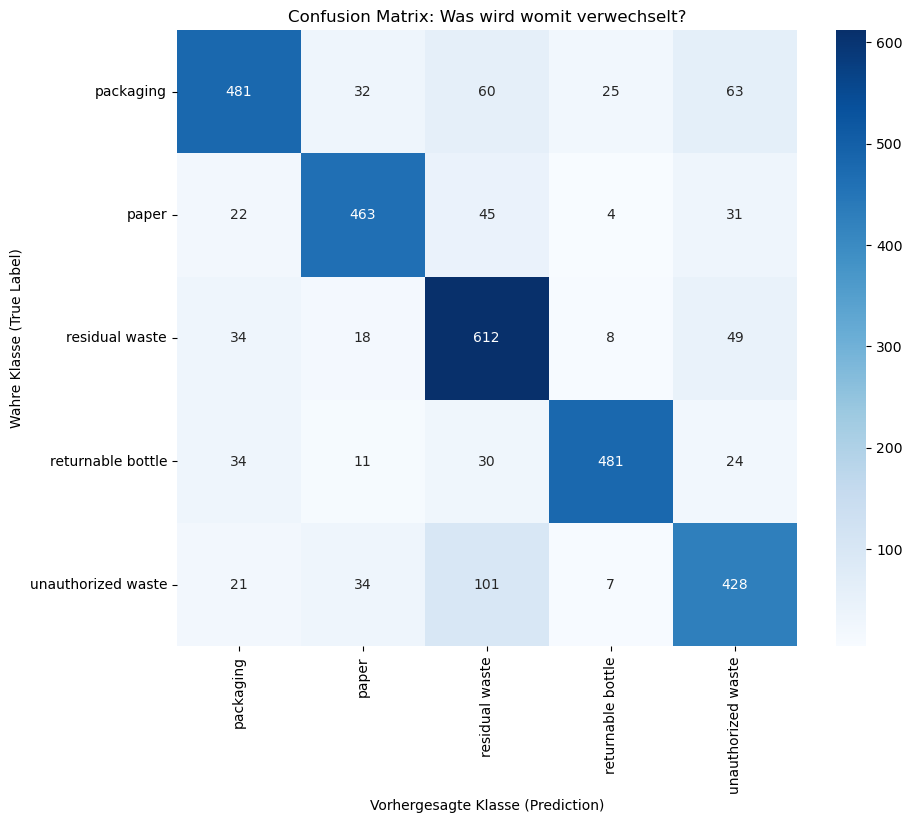

train_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▄▃▃▂▂▂▂▂▁▁
val_accuracy,▁▁▄▅▅▆▅▇▇▇▇███▇
val_loss,█▇▅▄▄▃▄▂▂▂▂▁▁▁▂
train_accuracy,78.59306
train_loss,0.5956
val_accuracy,79.41366
val_loss,0.60057


In [ ]:
extern_model_pipeline("Extern Data Transfer Learning with ResNet50", config_transfer_rn["finetune"])

### Hyperparameteroptimisation 

Sweep Konfigurationen (Hyperparameter Search-Space):

In [ ]:
parameters_mlp = { 
    'model_type': {
        'value': 'MLP'},
    'epochs': {
        'value': 15}, 
    'batch_size': {
        'value': 16},
    'learning_rate': {
        'values': [0.005,0.01,0.1]},  
    'hidden_dim': {
        'values': [32,64,128,256,512]}, 
    'dropout': {
        'values': [0.0,0.1,0.2,0.3,0.4]}
    }

In [ ]:
sweep_config = {
    "method" : "random",
    "parameters" : parameters_mlp
} 

In [ ]:
sweep_id=wandb.sweep(sweep_config,project=WANDB_PROJECT)

Create sweep with ID: gdpvhlxh
Sweep URL: https://wandb.ai/sltai/M%C3%BCll%20Klassifikation/sweeps/gdpvhlxh


In [ ]:
wandb.agent(sweep_id, function=lambda: extern_model_pipeline("MLP"), count=10)

In [ ]:
wandb.teardown()

In [ ]:
api = wandb.Api()
sweep = api.sweep('sltai/Müll Klassifikation/sweeps/gdpvhlxh')

In [ ]:
runs = sorted(sweep.runs,key=lambda run: run.summary.get("Accurracy Test",0), reverse=True)

In [ ]:
best_run = max(
    sweep.runs,
    key=lambda r: r.summary.get("val_accuracy", float("-inf"))
)

print(
    f"Best run {best_run.name} "
    f"with {best_run.summary['val_accuracy']:.2f}% validation accuracy"
)

Best run glorious-sweep-5 with 48.45% validation accuracy


In [ ]:
parameters_cnn = { 
    'model_type': {
        'value': 'CNN'},
    'epochs': {
        'value': 15}, 
    'batch_size': {
        'value': 16},
    'learning_rate': {
        'values': [0.005,0.01,0.1]},  
    'hidden_dim_1': {
        'values': [32,64,128,256,512,1024]}, 
    'dropout': {
        'values': [0.0,0.1,0.2,0.3,0.4]}
    }

In [ ]:
sweep_config = {
    "method" : "random",
    "parameters" : parameters_cnn
} 

In [ ]:
sweep_id=wandb.sweep(sweep_config,project=WANDB_PROJECT)

Create sweep with ID: e2fse1x2
Sweep URL: https://wandb.ai/sltai/M%C3%BCll%20Klassifikation/sweeps/e2fse1x2


In [ ]:
wandb.agent(sweep_id, function=lambda: extern_model_pipeline("CNN"), count=10)

In [ ]:
wandb.finish()

### Quellen <a id="quellen"></a>

[1] ALBA und Civey, "Gut gemeint: Große Mehrheit trennt den Müll und schadet dennoch dem Klima", Pressemitteilung, 20.07.2022. (Online). Verfügbar: https://www.alba.info/unternehmen/newsroom/pressemitteilungen/detail/gut-gemeint-grosse-mehrheit-trennt-den-muell-und-schadet-dennoch-dem-klima/. (Zugriff: 10.01.2026).

[2] L. Löwe, "Alles durcheinander: Die Unlust beim Mülltrennen", FR.de, 10.01.2019. (Online). Verfügbar: https://www.fr.de/ratgeber/wohnen/alles-durcheinander-unlust-beim-muelltrennen-11106084.html. (Zugriff: 15.01.2026). 